In [ ]:
import os, glob, json, threading, time, requests
try:
    # Notebook 7 / Jupyter Server
    from jupyter_server import serverapp as server_module
    list_servers = server_module.list_running_servers
except ImportError:
    # Classic Notebook
    from notebook import notebookapp as server_module
    list_servers = server_module.list_running_servers

def restart_kernel():
    # 1) 연결 파일에서 kernel_id 추출
    from jupyter_core.paths import jupyter_runtime_dir
    runtime_dir = jupyter_runtime_dir()
    cf = max(glob.glob(os.path.join(runtime_dir, 'kernel-*.json')), key=os.path.getmtime)
    kernel_id = os.path.basename(cf).replace('kernel-', '').replace('.json', '')
    
    # 2) 실행 중인 서버 정보 조회
    servers = list(list_servers())
    if not servers:
        print("⚠️ 실행 중인 Jupyter 서버를 찾을 수 없습니다.")
        return
    srv = servers[0]
    url = srv['url']
    token = srv.get('token', '')
    
    # 3) REST API 호출로 커널 재시작
    api = f"{url}api/kernels/{kernel_id}/restart"
    res = requests.post(api, params={'token': token})
    if res.ok:
        print(f"🔄 커널 {kernel_id} 재시작 성공 ({time.strftime('%X')})")
    else:
        print(f"❌ 재시작 실패 ({res.status_code}): {res.text}")

def schedule_restart(interval_min=30):
    def job():
        while True:
            time.sleep(interval_min * 60)
            restart_kernel()
    th = threading.Thread(target=job, daemon=True)
    th.start()

# 스케줄 시작 (30분마다 재시작)
schedule_restart(30)
print("✅ 30분마다 커널 재시작 스케줄러가 동작 중입니다.")


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
google_trend_crawl_270.py   (2025-06-12, full standalone)

기능
────
1. final.csv 의 name 열을 읽어 2023-01-01 ~ 2025-05-31(UTC) 구간을
   270 일+1 일 중복 청크로 나눠 일간 트렌드(TIMESERIES) 수집
2. 겹치는 1 일 값을 이용해 체인-링킹(CHAIN-LINK) 방식으로 스케일 조정
   - 시작·끝 값이 0 이면 스케일 불가 → unlinkable_keywords.csv 기록
   - **마지막 청크의 종료일 0 값은 허용**
3. 결과 CSV
   • data/raw_trends.csv        name,date,value,season
   • data/scaled_trends.csv     name,date,value,season,scaled_value
   • data/unlinkable_keywords.csv name,reason

실행
────
pip install python-dotenv pandas python-dateutil serpapi tqdm
python google_trend_crawl_270.py
"""
from __future__ import annotations

import json
import logging
import os
import sys
from datetime import datetime, timedelta, timezone
from pathlib import Path
from typing import List, Tuple

import pandas as pd
from dotenv import load_dotenv
from serpapi import GoogleSearch       # pip install google-search-results
from tqdm import tqdm

# ────────────────────────────── 설정
START_DATE   = datetime(2023, 1, 1, tzinfo=timezone.utc)
END_DATE     = datetime(2025, 5, 31, tzinfo=timezone.utc)
CHUNK_DAYS   = 270           # 270-day window (inclusive)
OVERLAP_DAYS = 1             # overlap size

RAW_CSV    = Path("data/raw_trends.csv")
SCALED_CSV = Path("data/scaled_trends.csv")
BAD_CSV    = Path("data/unlinkable_keywords.csv")

LOG_FILE   = Path("logs/trend_crawler.log")
CACHE_DIR  = Path("cache/trends_json")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────── 로깅
LOG_FILE.parent.mkdir(parents=True, exist_ok=True)
fmt = logging.Formatter("%(asctime)s %(levelname)s %(message)s")

file_handler = logging.FileHandler(LOG_FILE, mode="a", encoding="utf-8")
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(fmt)

console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))

logger = logging.getLogger()
if not logger.handlers:
    logger.setLevel(logging.DEBUG)
    logger.addHandler(file_handler)
    logger.addHandler(console)
else:
    # 중복 실행 시 콘솔 핸들러 중복 추가 방지
    if not any(isinstance(h, logging.StreamHandler) and h.stream is sys.stdout
               for h in logger.handlers):
        logger.addHandler(console)

# ────────────────────────────── API 키
load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY")
if not API_KEY:
    logger.error("SERPAPI_KEY 환경변수가 없습니다. .env에 추가하세요.")
    sys.exit(1)

# ────────────────────────────── 유틸
def generate_chunks(start: datetime, end: datetime) -> List[Tuple[datetime, datetime]]:
    """270-day + 1-day overlap 구간 리스트 반환."""
    chunks: List[Tuple[datetime, datetime]] = []
    cur_start = start
    while cur_start <= end:
        cur_end = min(cur_start + timedelta(days=CHUNK_DAYS - 1), end)
        chunks.append((cur_start, cur_end))
        if cur_end >= end:
            break
        cur_start = cur_end - timedelta(days=OVERLAP_DAYS - 1)
    return chunks


def parse_value(val_raw) -> int:
    """'16'·'1,234'·'<1' 등 문자열을 int로 변환, 오류는 0."""
    if val_raw in ("<1", "", None):
        return 0
    if isinstance(val_raw, (int, float)):
        return int(val_raw)
    try:
        return int(str(val_raw).replace(",", "").strip())
    except Exception:  # pragma: no cover
        return 0


def timeline_item_to_row(item: dict) -> dict | None:
    """timeline 항목을 dict(date,value)로 변환."""
    # 날짜
    if "date" in item and item["date"]:
        date_dt = pd.to_datetime(item["date"], utc=True, errors="coerce")
    else:
        date_dt = pd.NaT
    if pd.isna(date_dt) and "timestamp" in item:
        date_dt = pd.to_datetime(int(item["timestamp"]), unit="s", utc=True, errors="coerce")
    if pd.isna(date_dt):
        return None
    # 값
    if "value" in item:
        val_int = parse_value(item["value"])
    else:
        values_arr = item.get("values", [])
        if values_arr and isinstance(values_arr[0], dict):
            val_int = parse_value(values_arr[0].get("value", 0))
        else:
            val_int = 0
    return {"date": date_dt, "value": val_int}


def fetch_chunk(keyword: str, begin: datetime, finish: datetime) -> pd.DataFrame:
    """SerpApi로 한 청크 조회 → DataFrame(date,value)"""
    cache_fp = CACHE_DIR / f"{keyword}_{begin:%Y%m%d}_{finish:%Y%m%d}.json"
    if cache_fp.exists():
        data = json.loads(cache_fp.read_text(encoding="utf-8"))
    else:
        params = {
            "api_key": API_KEY,
            "engine": "google_trends",
            "q": keyword,
            "date": f"{begin:%Y-%m-%d} {finish:%Y-%m-%d}",  # UTC
            "data_type": "TIMESERIES",
            "output": "json",
        }
        try:
            data = GoogleSearch(params).get_dict()
        except Exception as e:
            logger.error("SerpApi 요청 실패 (%s): %s", keyword, e)
            raise
        cache_fp.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")

    timeline = (
        data.get("interest_over_time", {}).get("timeline")
        or data.get("interest_over_time", {}).get("timeline_data")
        or []
    )
    rows = []
    for item in timeline:
        row = timeline_item_to_row(item)
        if row:
            rows.append(row)
    if not rows:
        logger.warning("%s: No data %s → %s", keyword, begin.date(), finish.date())
    return pd.DataFrame(rows)


def has_bad_edges(frames: List[pd.DataFrame]) -> tuple[bool, str]:
    """
    시작·끝(단, 마지막 청크 끝 제외)·overlap 값이 0이면 True, reason 반환.
    """
    if not frames:
        return True, "empty frames"
    # 1) 청크 시작·끝 값
    for idx, df in enumerate(frames):
        if df.empty:
            return True, f"empty chunk {idx+1}"
        start_zero = df.iloc[0]["value"] == 0
        end_zero   = df.iloc[-1]["value"] == 0 and idx != len(frames) - 1
        if start_zero or end_zero:
            return True, "zero start/end"
    # 2) overlap 값
    for i in range(1, len(frames)):
        overlap_val_prev = frames[i-1].iloc[-1]["value"]
        overlap_val_curr = frames[i  ].iloc[0 ]["value"]
        if overlap_val_prev == 0 or overlap_val_curr == 0:
            return True, "zero overlap"
    return False, ""


def rescale_chunks(frames: List[pd.DataFrame]) -> List[pd.DataFrame]:
    """Chain-link scaling (B → A)"""
    if not frames:
        return []
    scaled = [frames[0].copy()]
    scaled[0]["scaled_value"] = scaled[0]["value"]
    for i in range(1, len(frames)):
        prev = scaled[-1]
        curr = frames[i].copy()
        overlap_day = curr.iloc[0]["date"]
        prev_val = prev.loc[prev["date"] == overlap_day, "scaled_value"].values[0]
        curr_val = curr.loc[curr["date"] == overlap_day, "value"].values[0]
        ratio = prev_val / curr_val if curr_val else 1.0
        curr["scaled_value"] = curr["value"] * ratio
        scaled.append(curr)
    return scaled


def append_csv(path: Path, df: pd.DataFrame):
    header = not path.exists()
    df.to_csv(path, mode="a", header=header, index=False)


# ────────────────────────────── main
def main():
    key_csv = Path("final.csv")
    if not key_csv.exists():
        logger.error("final.csv 가 없습니다.")
        return
    names = pd.read_csv(key_csv, usecols=["name"])["name"].dropna().unique().tolist()
    logger.info("Loaded %d keywords", len(names))

    # 스케줄 & CSV 헤더 준비
    schedule = generate_chunks(START_DATE, END_DATE)
    logger.info("Chunk schedule: %d chunks (270d, 1d overlap)", len(schedule))

    RAW_CSV.parent.mkdir(parents=True, exist_ok=True)
    for p in (RAW_CSV, SCALED_CSV, BAD_CSV):
        if not p.exists():
            p.parent.mkdir(parents=True, exist_ok=True)
            p.write_text("")  # 헤더는 append_csv에서 처리

    for kw in tqdm(names, desc="Keywords"):
        raw_frames: List[pd.DataFrame] = []
        for idx, (s, e) in enumerate(schedule):
            logger.debug("%s | chunk %02d: %s → %s", kw, idx + 1, s.date(), e.date())
            df = fetch_chunk(kw, s, e)
            df["season"] = idx + 1
            raw_frames.append(df)

        # edge 0 검증
        bad, reason = has_bad_edges(raw_frames)
        if bad:
            logger.info("⏭  %s skipped  – %s", kw, reason)
            append_csv(BAD_CSV, pd.DataFrame([{"name": kw, "reason": reason}]))
            continue

        raw_all = pd.concat(raw_frames, ignore_index=True)
        raw_all.insert(0, "name", kw)
        append_csv(RAW_CSV, raw_all)

        scaled_frames = rescale_chunks(raw_frames)
        scaled_all = pd.concat(scaled_frames, ignore_index=True)
        scaled_all.insert(0, "name", kw)
        append_csv(SCALED_CSV, scaled_all)

        logger.info("✔︎  %s 완료 (%d rows)", kw, len(raw_all))

    logger.info("All done → %s / %s / %s", RAW_CSV, SCALED_CSV, BAD_CSV)


if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        logger.warning("Interrupted by user. Exit.")


INFO: Loaded 347 keywords
INFO: Loaded 347 keywords
INFO: Chunk schedule: 4 chunks (270d, 1d overlap)
INFO: Chunk schedule: 4 chunks (270d, 1d overlap)


Keywords:   0%|          | 0/347 [00:00<?, ?it/s]

INFO: ✔︎  Donald Trump 완료 (885 rows)
INFO: ✔︎  Donald Trump 완료 (885 rows)


Keywords:   0%|          | 1/347 [00:00<02:21,  2.44it/s]

INFO: ✔︎  Joe Biden 완료 (885 rows)
INFO: ✔︎  Joe Biden 완료 (885 rows)


Keywords:   1%|          | 2/347 [00:00<02:22,  2.43it/s]

INFO: ✔︎  Pope Francis 완료 (885 rows)
INFO: ✔︎  Pope Francis 완료 (885 rows)


Keywords:   1%|          | 3/347 [00:01<02:31,  2.27it/s]

INFO: ✔︎  Benjamin Netanyahu 완료 (885 rows)
INFO: ✔︎  Benjamin Netanyahu 완료 (885 rows)


Keywords:   1%|          | 4/347 [00:01<02:27,  2.32it/s]

INFO: ⏭  Kamala Harris skipped  – zero start/end
INFO: ⏭  Kamala Harris skipped  – zero start/end


Keywords:   1%|▏         | 5/347 [00:02<02:24,  2.36it/s]

INFO: ✔︎  Taylor Swift 완료 (885 rows)
INFO: ✔︎  Taylor Swift 완료 (885 rows)


Keywords:   2%|▏         | 6/347 [00:02<02:27,  2.32it/s]

INFO: ✔︎  Elon Musk 완료 (885 rows)
INFO: ✔︎  Elon Musk 완료 (885 rows)


Keywords:   2%|▏         | 7/347 [00:02<02:22,  2.39it/s]

INFO: ✔︎  Narendra Modi 완료 (885 rows)
INFO: ✔︎  Narendra Modi 완료 (885 rows)


Keywords:   2%|▏         | 8/347 [00:03<02:20,  2.41it/s]

INFO: ✔︎  Cristiano Ronaldo 완료 (885 rows)
INFO: ✔︎  Cristiano Ronaldo 완료 (885 rows)


Keywords:   3%|▎         | 9/347 [00:03<02:17,  2.45it/s]

INFO: ✔︎  Keir Starmer 완료 (885 rows)
INFO: ✔︎  Keir Starmer 완료 (885 rows)


Keywords:   3%|▎         | 10/347 [00:04<02:15,  2.49it/s]

INFO: ✔︎  Hunter Biden 완료 (885 rows)
INFO: ✔︎  Hunter Biden 완료 (885 rows)


Keywords:   3%|▎         | 11/347 [00:04<02:12,  2.53it/s]

INFO: ✔︎  King Charles 완료 (885 rows)
INFO: ✔︎  King Charles 완료 (885 rows)


Keywords:   3%|▎         | 12/347 [00:04<02:12,  2.54it/s]

INFO: ✔︎  Rahul Gandhi 완료 (885 rows)
INFO: ✔︎  Rahul Gandhi 완료 (885 rows)


Keywords:   4%|▎         | 13/347 [00:05<02:12,  2.52it/s]

INFO: ✔︎  Anthony Albanese 완료 (885 rows)
INFO: ✔︎  Anthony Albanese 완료 (885 rows)


Keywords:   4%|▍         | 14/347 [00:05<02:09,  2.56it/s]

INFO: ✔︎  Barack Obama 완료 (885 rows)
INFO: ✔︎  Barack Obama 완료 (885 rows)


Keywords:   4%|▍         | 15/347 [00:06<02:09,  2.57it/s]

INFO: ✔︎  Justin Trudeau 완료 (885 rows)
INFO: ✔︎  Justin Trudeau 완료 (885 rows)


Keywords:   5%|▍         | 16/347 [00:06<02:07,  2.60it/s]

INFO: ✔︎  Antony Blinken 완료 (885 rows)
INFO: ✔︎  Antony Blinken 완료 (885 rows)


Keywords:   5%|▍         | 17/347 [00:06<02:11,  2.51it/s]

INFO: ✔︎  Imran Khan 완료 (885 rows)
INFO: ✔︎  Imran Khan 완료 (885 rows)


Keywords:   5%|▌         | 18/347 [00:07<02:09,  2.55it/s]

INFO: ✔︎  Boris Johnson 완료 (885 rows)
INFO: ✔︎  Boris Johnson 완료 (885 rows)


Keywords:   5%|▌         | 19/347 [00:07<02:07,  2.57it/s]

INFO: ⏭  Jens Stoltenberg skipped  – zero start/end
INFO: ⏭  Jens Stoltenberg skipped  – zero start/end


Keywords:   6%|▌         | 20/347 [00:08<02:04,  2.63it/s]

INFO: ⏭  Alexander Lukashenko skipped  – zero start/end
INFO: ⏭  Alexander Lukashenko skipped  – zero start/end


Keywords:   6%|▌         | 21/347 [00:08<02:03,  2.64it/s]

INFO: ✔︎  Volodymyr Zelenskyy 완료 (885 rows)
INFO: ✔︎  Volodymyr Zelenskyy 완료 (885 rows)


Keywords:   6%|▋         | 22/347 [00:08<02:03,  2.64it/s]

INFO: ⏭  Alexander Ovechkin skipped  – zero start/end
INFO: ⏭  Alexander Ovechkin skipped  – zero start/end


Keywords:   7%|▋         | 23/347 [00:09<02:02,  2.65it/s]

INFO: ⏭  Nikki Haley skipped  – zero start/end
INFO: ⏭  Nikki Haley skipped  – zero start/end


Keywords:   7%|▋         | 24/347 [00:09<02:01,  2.66it/s]

INFO: ⏭  Peter Dutton skipped  – zero start/end
INFO: ⏭  Peter Dutton skipped  – zero start/end


Keywords:   7%|▋         | 25/347 [00:09<02:00,  2.67it/s]

INFO: ⏭  Lloyd Austin skipped  – zero start/end
INFO: ⏭  Lloyd Austin skipped  – zero start/end


Keywords:   7%|▋         | 26/347 [00:10<01:58,  2.70it/s]

INFO: ⏭  Mike Johnson skipped  – zero start/end
INFO: ⏭  Mike Johnson skipped  – zero start/end


Keywords:   8%|▊         | 27/347 [00:10<01:59,  2.68it/s]

INFO: ✔︎  Travis Kelce 완료 (885 rows)
INFO: ✔︎  Travis Kelce 완료 (885 rows)


Keywords:   8%|▊         | 28/347 [00:11<01:59,  2.66it/s]

INFO: ⏭  Sheikh Hasina skipped  – zero start/end
INFO: ⏭  Sheikh Hasina skipped  – zero start/end


Keywords:   8%|▊         | 29/347 [00:11<01:58,  2.69it/s]

INFO: ✔︎  Gavin Newsom 완료 (885 rows)
INFO: ✔︎  Gavin Newsom 완료 (885 rows)


Keywords:   9%|▊         | 30/347 [00:11<01:58,  2.69it/s]

INFO: ✔︎  Amit Shah 완료 (885 rows)
INFO: ✔︎  Amit Shah 완료 (885 rows)


Keywords:   9%|▉         | 31/347 [00:12<01:57,  2.69it/s]

INFO: ✔︎  Hillary Clinton 완료 (885 rows)
INFO: ✔︎  Hillary Clinton 완료 (885 rows)


Keywords:   9%|▉         | 32/347 [00:12<02:01,  2.59it/s]

INFO: ⏭  Dmitry Peskov skipped  – zero start/end
INFO: ⏭  Dmitry Peskov skipped  – zero start/end


Keywords:  10%|▉         | 33/347 [00:12<02:06,  2.48it/s]

INFO: ⏭  Jimmy Carter skipped  – zero start/end
INFO: ⏭  Jimmy Carter skipped  – zero start/end


Keywords:  10%|▉         | 34/347 [00:13<02:03,  2.53it/s]

INFO: ⏭  Tim Walz skipped  – zero start/end
INFO: ⏭  Tim Walz skipped  – zero start/end


Keywords:  10%|█         | 35/347 [00:13<02:00,  2.59it/s]

INFO: ⏭  Ramzan Kadyrov skipped  – zero start/end
INFO: ⏭  Ramzan Kadyrov skipped  – zero start/end


Keywords:  10%|█         | 36/347 [00:14<01:58,  2.64it/s]

INFO: ✔︎  Marco Rubio 완료 (885 rows)
INFO: ✔︎  Marco Rubio 완료 (885 rows)


Keywords:  11%|█         | 37/347 [00:14<01:58,  2.62it/s]

INFO: ✔︎  Michael Cohen 완료 (885 rows)
INFO: ✔︎  Michael Cohen 완료 (885 rows)


Keywords:  11%|█         | 38/347 [00:14<01:59,  2.58it/s]

INFO: ✔︎  Arvind Kejriwal 완료 (885 rows)
INFO: ✔︎  Arvind Kejriwal 완료 (885 rows)


Keywords:  11%|█         | 39/347 [00:15<02:02,  2.52it/s]

INFO: ✔︎  Jerome Powell 완료 (885 rows)
INFO: ✔︎  Jerome Powell 완료 (885 rows)


Keywords:  12%|█▏        | 40/347 [00:15<02:01,  2.53it/s]

INFO: ✔︎  Elton John 완료 (885 rows)
INFO: ✔︎  Elton John 완료 (885 rows)


Keywords:  12%|█▏        | 41/347 [00:16<02:00,  2.54it/s]

INFO: ⏭  Kate Middleton skipped  – zero start/end
INFO: ⏭  Kate Middleton skipped  – zero start/end


Keywords:  12%|█▏        | 42/347 [00:16<01:57,  2.60it/s]

INFO: ⏭  Queen Camilla skipped  – zero start/end
INFO: ⏭  Queen Camilla skipped  – zero start/end


Keywords:  12%|█▏        | 43/347 [00:16<01:54,  2.65it/s]

INFO: ✔︎  Jennifer Lopez 완료 (885 rows)
INFO: ✔︎  Jennifer Lopez 완료 (885 rows)


Keywords:  13%|█▎        | 44/347 [00:17<01:55,  2.63it/s]

INFO: ✔︎  Novak Djokovic 완료 (885 rows)
INFO: ✔︎  Novak Djokovic 완료 (885 rows)


Keywords:  13%|█▎        | 45/347 [00:17<01:57,  2.58it/s]

INFO: ✔︎  Kim Kardashian 완료 (885 rows)
INFO: ✔︎  Kim Kardashian 완료 (885 rows)


Keywords:  13%|█▎        | 46/347 [00:17<01:56,  2.59it/s]

INFO: ✔︎  Lady Gaga 완료 (885 rows)
INFO: ✔︎  Lady Gaga 완료 (885 rows)


Keywords:  14%|█▎        | 47/347 [00:18<01:55,  2.59it/s]

INFO: ✔︎  Bill Clinton 완료 (885 rows)
INFO: ✔︎  Bill Clinton 완료 (885 rows)


Keywords:  14%|█▍        | 48/347 [00:18<01:55,  2.59it/s]

INFO: ✔︎  Warren Buffett 완료 (885 rows)
INFO: ✔︎  Warren Buffett 완료 (885 rows)


Keywords:  14%|█▍        | 49/347 [00:19<01:55,  2.58it/s]

INFO: ⏭  Stormy Daniels skipped  – zero start/end
INFO: ⏭  Stormy Daniels skipped  – zero start/end


Keywords:  14%|█▍        | 50/347 [00:19<01:52,  2.63it/s]

INFO: ✔︎  Mike Pence 완료 (885 rows)
INFO: ✔︎  Mike Pence 완료 (885 rows)


Keywords:  15%|█▍        | 51/347 [00:19<01:53,  2.60it/s]

INFO: ⏭  Nikita Mikhalkov skipped  – zero start/end
INFO: ⏭  Nikita Mikhalkov skipped  – zero start/end


Keywords:  15%|█▍        | 52/347 [00:20<01:43,  2.86it/s]

INFO: ⏭  Rachel Reeves skipped  – zero start/end
INFO: ⏭  Rachel Reeves skipped  – zero start/end


Keywords:  15%|█▌        | 53/347 [00:20<01:44,  2.80it/s]

INFO: ✔︎  Kanye West 완료 (885 rows)
INFO: ✔︎  Kanye West 완료 (885 rows)


Keywords:  16%|█▌        | 54/347 [00:20<01:50,  2.65it/s]

INFO: ✔︎  Morgan Wallen 완료 (885 rows)
INFO: ✔︎  Morgan Wallen 완료 (885 rows)


Keywords:  16%|█▌        | 55/347 [00:21<01:54,  2.55it/s]

INFO: ✔︎  Dolly Parton 완료 (885 rows)
INFO: ✔︎  Dolly Parton 완료 (885 rows)


Keywords:  16%|█▌        | 56/347 [00:21<01:54,  2.55it/s]

INFO: ✔︎  Britney Spears 완료 (885 rows)
INFO: ✔︎  Britney Spears 완료 (885 rows)


Keywords:  16%|█▋        | 57/347 [00:22<01:53,  2.56it/s]

INFO: ✔︎  Salman Khan 완료 (885 rows)
INFO: ✔︎  Salman Khan 완료 (885 rows)


Keywords:  17%|█▋        | 58/347 [00:22<01:55,  2.50it/s]

INFO: ✔︎  Olaf Scholz 완료 (885 rows)
INFO: ✔︎  Olaf Scholz 완료 (885 rows)


Keywords:  17%|█▋        | 59/347 [00:22<01:53,  2.53it/s]

INFO: ✔︎  Mark Zuckerberg 완료 (885 rows)
INFO: ✔︎  Mark Zuckerberg 완료 (885 rows)


Keywords:  17%|█▋        | 60/347 [00:23<01:52,  2.55it/s]

INFO: ⏭  Silvio Berlusconi skipped  – zero start/end
INFO: ⏭  Silvio Berlusconi skipped  – zero start/end


Keywords:  18%|█▊        | 61/347 [00:23<01:50,  2.59it/s]

INFO: ✔︎  Jill Biden 완료 (885 rows)
INFO: ✔︎  Jill Biden 완료 (885 rows)


Keywords:  18%|█▊        | 62/347 [00:24<01:49,  2.59it/s]

INFO: ⏭  Tucker Carlson skipped  – zero start/end
INFO: ⏭  Tucker Carlson skipped  – zero start/end


Keywords:  18%|█▊        | 63/347 [00:24<01:47,  2.63it/s]

INFO: ✔︎  Nancy Pelosi 완료 (885 rows)
INFO: ✔︎  Nancy Pelosi 완료 (885 rows)


Keywords:  18%|█▊        | 64/347 [00:24<01:48,  2.61it/s]

INFO: ✔︎  Kendrick Lamar 완료 (885 rows)
INFO: ✔︎  Kendrick Lamar 완료 (885 rows)


Keywords:  19%|█▊        | 65/347 [00:25<01:47,  2.62it/s]

INFO: ⏭  Ajit Pawar skipped  – zero start/end
INFO: ⏭  Ajit Pawar skipped  – zero start/end


Keywords:  19%|█▉        | 66/347 [00:25<01:50,  2.54it/s]

INFO: ⏭  Denis Pushilin skipped  – zero start/end
INFO: ⏭  Denis Pushilin skipped  – zero start/end


Keywords:  19%|█▉        | 67/347 [00:25<01:28,  3.18it/s]

INFO: ✔︎  Selena Gomez 완료 (885 rows)
INFO: ✔︎  Selena Gomez 완료 (885 rows)


Keywords:  20%|█▉        | 68/347 [00:26<01:35,  2.92it/s]

INFO: ✔︎  Bill Gates 완료 (885 rows)
INFO: ✔︎  Bill Gates 완료 (885 rows)


Keywords:  20%|█▉        | 69/347 [00:26<01:39,  2.79it/s]

INFO: ✔︎  Ariana Grande 완료 (885 rows)
INFO: ✔︎  Ariana Grande 완료 (885 rows)


Keywords:  20%|██        | 70/347 [00:26<01:41,  2.73it/s]

INFO: ✔︎  Janet Yellen 완료 (885 rows)
INFO: ✔︎  Janet Yellen 완료 (885 rows)


Keywords:  20%|██        | 71/347 [00:27<01:45,  2.63it/s]

INFO: ✔︎  Greg Abbott 완료 (885 rows)
INFO: ✔︎  Greg Abbott 완료 (885 rows)


Keywords:  21%|██        | 72/347 [00:27<01:44,  2.63it/s]

INFO: ✔︎  Mohamed Salah 완료 (885 rows)
INFO: ✔︎  Mohamed Salah 완료 (885 rows)


Keywords:  21%|██        | 73/347 [00:28<01:47,  2.55it/s]

INFO: ⏭  Eric Adams skipped  – zero start/end
INFO: ⏭  Eric Adams skipped  – zero start/end


Keywords:  21%|██▏       | 74/347 [00:28<01:45,  2.59it/s]

INFO: ⏭  Fumio Kishida skipped  – zero start/end
INFO: ⏭  Fumio Kishida skipped  – zero start/end


Keywords:  22%|██▏       | 75/347 [00:28<01:43,  2.64it/s]

INFO: ✔︎  Sharad Pawar 완료 (885 rows)
INFO: ✔︎  Sharad Pawar 완료 (885 rows)


Keywords:  22%|██▏       | 76/347 [00:29<01:43,  2.62it/s]

INFO: ⏭  Jeremy Hunt skipped  – zero start/end
INFO: ⏭  Jeremy Hunt skipped  – zero start/end


Keywords:  22%|██▏       | 77/347 [00:29<01:41,  2.67it/s]

INFO: ⏭  Yoon Suk Yeol skipped  – zero start/end
INFO: ⏭  Yoon Suk Yeol skipped  – zero start/end


Keywords:  22%|██▏       | 78/347 [00:30<01:39,  2.70it/s]

INFO: ✔︎  Katy Perry 완료 (885 rows)
INFO: ✔︎  Katy Perry 완료 (885 rows)


Keywords:  23%|██▎       | 79/347 [00:30<01:39,  2.68it/s]

INFO: ⏭  Lisa Marie skipped  – zero start/end
INFO: ⏭  Lisa Marie skipped  – zero start/end


Keywords:  23%|██▎       | 80/347 [00:30<01:38,  2.71it/s]

INFO: ✔︎  Nigel Farage 완료 (885 rows)
INFO: ✔︎  Nigel Farage 완료 (885 rows)


Keywords:  23%|██▎       | 81/347 [00:31<01:38,  2.70it/s]

INFO: ✔︎  Tom Brady 완료 (885 rows)
INFO: ✔︎  Tom Brady 완료 (885 rows)


Keywords:  24%|██▎       | 82/347 [00:31<01:38,  2.69it/s]

INFO: ⏭  Vivek Ramaswamy skipped  – zero start/end
INFO: ⏭  Vivek Ramaswamy skipped  – zero start/end


Keywords:  24%|██▍       | 83/347 [00:31<01:39,  2.65it/s]

INFO: ✔︎  Ben Affleck 완료 (885 rows)
INFO: ✔︎  Ben Affleck 완료 (885 rows)


Keywords:  24%|██▍       | 84/347 [00:32<01:41,  2.58it/s]

INFO: ✔︎  Bob Dylan 완료 (885 rows)
INFO: ✔︎  Bob Dylan 완료 (885 rows)


Keywords:  24%|██▍       | 85/347 [00:32<01:42,  2.56it/s]

INFO: ✔︎  Patrick Mahomes 완료 (885 rows)
INFO: ✔︎  Patrick Mahomes 완료 (885 rows)


Keywords:  25%|██▍       | 86/347 [00:33<01:51,  2.35it/s]

INFO: ⏭  Humza Yousaf skipped  – zero start/end
INFO: ⏭  Humza Yousaf skipped  – zero start/end


Keywords:  25%|██▌       | 87/347 [00:33<01:47,  2.43it/s]

INFO: ✔︎  Kathy Hochul 완료 (885 rows)
INFO: ✔︎  Kathy Hochul 완료 (885 rows)


Keywords:  25%|██▌       | 88/347 [00:34<01:52,  2.30it/s]

INFO: ✔︎  Tom Cruise 완료 (885 rows)
INFO: ✔︎  Tom Cruise 완료 (885 rows)


Keywords:  26%|██▌       | 89/347 [00:34<01:53,  2.27it/s]

INFO: ⏭  Mark Carney skipped  – zero start/end
INFO: ⏭  Mark Carney skipped  – zero start/end


Keywords:  26%|██▌       | 90/347 [00:34<01:48,  2.38it/s]

INFO: ⏭  Jake Sullivan skipped  – zero start/end
INFO: ⏭  Jake Sullivan skipped  – zero start/end


Keywords:  26%|██▌       | 91/347 [00:35<01:44,  2.45it/s]

INFO: ✔︎  Carrie Underwood 완료 (885 rows)
INFO: ✔︎  Carrie Underwood 완료 (885 rows)


Keywords:  27%|██▋       | 92/347 [00:35<01:42,  2.50it/s]

INFO: ⏭  Alvin Bragg skipped  – zero start/end
INFO: ⏭  Alvin Bragg skipped  – zero start/end


Keywords:  27%|██▋       | 93/347 [00:36<01:39,  2.55it/s]

INFO: ✔︎  Billie Eilish 완료 (885 rows)
INFO: ✔︎  Billie Eilish 완료 (885 rows)


Keywords:  27%|██▋       | 94/347 [00:36<01:41,  2.50it/s]

INFO: ⏭  Pete Hegseth skipped  – zero start/end
INFO: ⏭  Pete Hegseth skipped  – zero start/end


Keywords:  27%|██▋       | 95/347 [00:36<01:41,  2.49it/s]

INFO: ✔︎  Bruce Springsteen 완료 (885 rows)
INFO: ✔︎  Bruce Springsteen 완료 (885 rows)


Keywords:  28%|██▊       | 96/347 [00:37<01:45,  2.37it/s]

INFO: ⏭  Dmitry Rogozin skipped  – zero start/end
INFO: ⏭  Dmitry Rogozin skipped  – zero start/end


Keywords:  28%|██▊       | 97/347 [00:37<01:42,  2.43it/s]

INFO: ⏭  Suella Braverman skipped  – zero start/end
INFO: ⏭  Suella Braverman skipped  – zero start/end


Keywords:  28%|██▊       | 98/347 [00:38<01:49,  2.28it/s]

INFO: ✔︎  Mamata Banerjee 완료 (885 rows)
INFO: ✔︎  Mamata Banerjee 완료 (885 rows)


Keywords:  29%|██▊       | 99/347 [00:38<01:52,  2.21it/s]

INFO: ✔︎  Pierre Poilievre 완료 (885 rows)
INFO: ✔︎  Pierre Poilievre 완료 (885 rows)


Keywords:  29%|██▉       | 100/347 [00:39<01:51,  2.22it/s]

INFO: ⏭  Hassan Nasrallah skipped  – zero start/end
INFO: ⏭  Hassan Nasrallah skipped  – zero start/end


Keywords:  29%|██▉       | 101/347 [00:39<01:51,  2.21it/s]

INFO: ⏭  Ismail Haniyeh skipped  – empty chunk 1
INFO: ⏭  Ismail Haniyeh skipped  – empty chunk 1


Keywords:  29%|██▉       | 102/347 [00:39<01:40,  2.45it/s]

INFO: ✔︎  Miley Cyrus 완료 (885 rows)
INFO: ✔︎  Miley Cyrus 완료 (885 rows)


Keywords:  30%|██▉       | 103/347 [00:40<01:43,  2.37it/s]

INFO: ✔︎  Luke Bryan 완료 (885 rows)
INFO: ✔︎  Luke Bryan 완료 (885 rows)


Keywords:  30%|██▉       | 104/347 [00:40<01:42,  2.36it/s]

INFO: ✔︎  Lewis Hamilton 완료 (885 rows)
INFO: ✔︎  Lewis Hamilton 완료 (885 rows)


Keywords:  30%|███       | 105/347 [00:41<01:43,  2.33it/s]

INFO: ✔︎  Kelly Clarkson 완료 (885 rows)
INFO: ✔︎  Kelly Clarkson 완료 (885 rows)


Keywords:  31%|███       | 106/347 [00:41<01:46,  2.26it/s]

INFO: ✔︎  Alec Baldwin 완료 (885 rows)
INFO: ✔︎  Alec Baldwin 완료 (885 rows)


Keywords:  31%|███       | 107/347 [00:42<01:45,  2.27it/s]

INFO: ✔︎  Justin Bieber 완료 (885 rows)
INFO: ✔︎  Justin Bieber 완료 (885 rows)


Keywords:  31%|███       | 108/347 [00:42<01:45,  2.27it/s]

INFO: ⏭  Alla Pugacheva skipped  – zero start/end
INFO: ⏭  Alla Pugacheva skipped  – zero start/end


Keywords:  31%|███▏      | 109/347 [00:43<01:44,  2.28it/s]

INFO: ⏭  Tatiana Tarasova skipped  – empty chunk 1
INFO: ⏭  Tatiana Tarasova skipped  – empty chunk 1


Keywords:  32%|███▏      | 110/347 [00:43<01:33,  2.53it/s]

INFO: ⏭  Dmitry Azarov skipped  – zero start/end
INFO: ⏭  Dmitry Azarov skipped  – zero start/end


Keywords:  32%|███▏      | 111/347 [00:43<01:35,  2.48it/s]

INFO: ✔︎  Snoop Dogg 완료 (885 rows)
INFO: ✔︎  Snoop Dogg 완료 (885 rows)


Keywords:  32%|███▏      | 112/347 [00:44<01:38,  2.39it/s]

INFO: ✔︎  Ryan Reynolds 완료 (885 rows)
INFO: ✔︎  Ryan Reynolds 완료 (885 rows)


Keywords:  33%|███▎      | 113/347 [00:44<01:38,  2.37it/s]

INFO: ✔︎  Marjorie Taylor Greene 완료 (885 rows)
INFO: ✔︎  Marjorie Taylor Greene 완료 (885 rows)


Keywords:  33%|███▎      | 114/347 [00:45<01:39,  2.34it/s]

INFO: ⏭  Matthew Perry skipped  – zero start/end
INFO: ⏭  Matthew Perry skipped  – zero start/end


Keywords:  33%|███▎      | 115/347 [00:45<01:38,  2.35it/s]

INFO: ✔︎  Angelina Jolie 완료 (885 rows)
INFO: ✔︎  Angelina Jolie 완료 (885 rows)


Keywords:  33%|███▎      | 116/347 [00:45<01:38,  2.34it/s]

INFO: ✔︎  Bobby Bones 완료 (885 rows)
INFO: ✔︎  Bobby Bones 완료 (885 rows)


Keywords:  34%|███▎      | 117/347 [00:46<01:38,  2.34it/s]

INFO: ⏭  Sergei Lavrov skipped  – zero start/end
INFO: ⏭  Sergei Lavrov skipped  – zero start/end


Keywords:  34%|███▍      | 118/347 [00:46<01:37,  2.34it/s]

INFO: ⏭  Anastasia Volochkova skipped  – zero start/end
INFO: ⏭  Anastasia Volochkova skipped  – zero start/end


Keywords:  34%|███▍      | 119/347 [00:47<01:40,  2.28it/s]

INFO: ⏭  Mahmoud Abbas skipped  – zero start/end
INFO: ⏭  Mahmoud Abbas skipped  – zero start/end


Keywords:  35%|███▍      | 120/347 [00:47<01:40,  2.26it/s]

INFO: ✔︎  Margot Robbie 완료 (885 rows)
INFO: ✔︎  Margot Robbie 완료 (885 rows)


Keywords:  35%|███▍      | 121/347 [00:48<01:40,  2.25it/s]

INFO: ⏭  Matt Gaetz skipped  – zero start/end
INFO: ⏭  Matt Gaetz skipped  – zero start/end


Keywords:  35%|███▌      | 122/347 [00:48<01:39,  2.27it/s]

INFO: ✔︎  Dua Lipa 완료 (885 rows)
INFO: ✔︎  Dua Lipa 완료 (885 rows)


Keywords:  35%|███▌      | 123/347 [00:49<01:38,  2.29it/s]

INFO: ✔︎  Karim Benzema 완료 (885 rows)
INFO: ✔︎  Karim Benzema 완료 (885 rows)


Keywords:  36%|███▌      | 124/347 [00:49<01:38,  2.26it/s]

INFO: ✔︎  Lionel Messi 완료 (885 rows)
INFO: ✔︎  Lionel Messi 완료 (885 rows)


Keywords:  36%|███▌      | 125/347 [00:49<01:37,  2.28it/s]

INFO: ✔︎  Harry Styles 완료 (885 rows)
INFO: ✔︎  Harry Styles 완료 (885 rows)


Keywords:  36%|███▋      | 126/347 [00:50<01:36,  2.28it/s]

INFO: ✔︎  Hakeem Jeffries 완료 (885 rows)
INFO: ✔︎  Hakeem Jeffries 완료 (885 rows)


Keywords:  37%|███▋      | 127/347 [00:50<01:36,  2.29it/s]

INFO: ✔︎  Shah Rukh Khan 완료 (885 rows)
INFO: ✔︎  Shah Rukh Khan 완료 (885 rows)


Keywords:  37%|███▋      | 128/347 [00:51<01:35,  2.28it/s]

INFO: ⏭  Alexander Bastrykin skipped  – empty chunk 1
INFO: ⏭  Alexander Bastrykin skipped  – empty chunk 1


Keywords:  37%|███▋      | 129/347 [00:51<01:25,  2.55it/s]

INFO: ⏭  Alexei Navalny skipped  – zero start/end
INFO: ⏭  Alexei Navalny skipped  – zero start/end


Keywords:  37%|███▋      | 130/347 [00:51<01:26,  2.51it/s]

INFO: ⏭  Shehbaz Sharif skipped  – zero start/end
INFO: ⏭  Shehbaz Sharif skipped  – zero start/end


Keywords:  38%|███▊      | 131/347 [00:52<01:32,  2.34it/s]

INFO: ⏭  James Cleverly skipped  – zero start/end
INFO: ⏭  James Cleverly skipped  – zero start/end


Keywords:  38%|███▊      | 132/347 [00:52<01:38,  2.18it/s]

INFO: ✔︎  Graham Potter 완료 (885 rows)
INFO: ✔︎  Graham Potter 완료 (885 rows)


Keywords:  38%|███▊      | 133/347 [00:53<01:36,  2.21it/s]

INFO: ⏭  Valery Meladze skipped  – zero start/end
INFO: ⏭  Valery Meladze skipped  – zero start/end


Keywords:  39%|███▊      | 134/347 [00:53<01:34,  2.27it/s]

INFO: ✔︎  Miranda Lambert 완료 (885 rows)
INFO: ✔︎  Miranda Lambert 완료 (885 rows)


Keywords:  39%|███▉      | 135/347 [00:54<01:32,  2.29it/s]

INFO: ✔︎  Isabel Diaz 완료 (885 rows)
INFO: ✔︎  Isabel Diaz 완료 (885 rows)


Keywords:  39%|███▉      | 136/347 [00:54<01:32,  2.29it/s]

INFO: ✔︎  Ed Sheeran 완료 (885 rows)
INFO: ✔︎  Ed Sheeran 완료 (885 rows)


Keywords:  39%|███▉      | 137/347 [00:55<01:30,  2.31it/s]

INFO: ⏭  Ali Khamenei skipped  – zero start/end
INFO: ⏭  Ali Khamenei skipped  – zero start/end


Keywords:  40%|███▉      | 138/347 [00:55<01:31,  2.29it/s]

INFO: ✔︎  Brad Pitt 완료 (885 rows)
INFO: ✔︎  Brad Pitt 완료 (885 rows)


Keywords:  40%|████      | 139/347 [00:55<01:30,  2.31it/s]

INFO: ⏭  Yevgeny Prigozhin skipped  – zero start/end
INFO: ⏭  Yevgeny Prigozhin skipped  – zero start/end


Keywords:  40%|████      | 140/347 [00:56<01:29,  2.31it/s]

INFO: ✔︎  Nawaz Sharif 완료 (885 rows)
INFO: ✔︎  Nawaz Sharif 완료 (885 rows)


Keywords:  41%|████      | 141/347 [00:56<01:30,  2.29it/s]

INFO: ✔︎  Keith Urban 완료 (885 rows)
INFO: ✔︎  Keith Urban 완료 (885 rows)


Keywords:  41%|████      | 142/347 [00:57<01:29,  2.30it/s]

INFO: ⏭  Letitia James skipped  – zero start/end
INFO: ⏭  Letitia James skipped  – zero start/end


Keywords:  41%|████      | 143/347 [00:57<01:27,  2.32it/s]

INFO: ✔︎  Nicole Kidman 완료 (885 rows)
INFO: ✔︎  Nicole Kidman 완료 (885 rows)


Keywords:  41%|████▏     | 144/347 [00:58<01:27,  2.31it/s]

INFO: ⏭  Josh Shapiro skipped  – zero start/end
INFO: ⏭  Josh Shapiro skipped  – zero start/end


Keywords:  42%|████▏     | 145/347 [00:58<01:26,  2.32it/s]

INFO: ✔︎  Blake Shelton 완료 (885 rows)
INFO: ✔︎  Blake Shelton 완료 (885 rows)


Keywords:  42%|████▏     | 146/347 [00:59<01:28,  2.27it/s]

INFO: ✔︎  Eknath Shinde 완료 (885 rows)
INFO: ✔︎  Eknath Shinde 완료 (885 rows)


Keywords:  42%|████▏     | 147/347 [00:59<01:27,  2.30it/s]

INFO: ✔︎  Aaron Rodgers 완료 (885 rows)
INFO: ✔︎  Aaron Rodgers 완료 (885 rows)


Keywords:  43%|████▎     | 148/347 [00:59<01:26,  2.29it/s]

INFO: ✔︎  Jeff Bezos 완료 (885 rows)
INFO: ✔︎  Jeff Bezos 완료 (885 rows)


Keywords:  43%|████▎     | 149/347 [01:00<01:27,  2.26it/s]

INFO: ⏭  Karoline Leavitt skipped  – zero start/end
INFO: ⏭  Karoline Leavitt skipped  – zero start/end


Keywords:  43%|████▎     | 150/347 [01:00<01:25,  2.31it/s]

INFO: ✔︎  Sabrina Carpenter 완료 (885 rows)
INFO: ✔︎  Sabrina Carpenter 완료 (885 rows)


Keywords:  44%|████▎     | 151/347 [01:01<01:25,  2.29it/s]

INFO: ✔︎  Giorgia Meloni 완료 (885 rows)
INFO: ✔︎  Giorgia Meloni 완료 (885 rows)


Keywords:  44%|████▍     | 152/347 [01:01<01:25,  2.27it/s]

INFO: ✔︎  Will Smith 완료 (885 rows)
INFO: ✔︎  Will Smith 완료 (885 rows)


Keywords:  44%|████▍     | 153/347 [01:02<01:25,  2.28it/s]

INFO: ✔︎  Tim Scott 완료 (885 rows)
INFO: ✔︎  Tim Scott 완료 (885 rows)


Keywords:  44%|████▍     | 154/347 [01:02<01:25,  2.26it/s]

INFO: ✔︎  Oprah Winfrey 완료 (885 rows)
INFO: ✔︎  Oprah Winfrey 완료 (885 rows)


Keywords:  45%|████▍     | 155/347 [01:02<01:23,  2.29it/s]

INFO: ✔︎  Nicki Minaj 완료 (885 rows)
INFO: ✔︎  Nicki Minaj 완료 (885 rows)


Keywords:  45%|████▍     | 156/347 [01:03<01:22,  2.30it/s]

INFO: ✔︎  Jim Jordan 완료 (885 rows)
INFO: ✔︎  Jim Jordan 완료 (885 rows)


Keywords:  45%|████▌     | 157/347 [01:03<01:22,  2.31it/s]

INFO: ✔︎  Jennifer Aniston 완료 (885 rows)
INFO: ✔︎  Jennifer Aniston 완료 (885 rows)


Keywords:  46%|████▌     | 158/347 [01:04<01:22,  2.28it/s]

INFO: ✔︎  Wang Yi 완료 (885 rows)
INFO: ✔︎  Wang Yi 완료 (885 rows)


Keywords:  46%|████▌     | 159/347 [01:04<01:26,  2.17it/s]

INFO: ✔︎  Shohei Ohtani 완료 (885 rows)
INFO: ✔︎  Shohei Ohtani 완료 (885 rows)


Keywords:  46%|████▌     | 160/347 [01:05<01:26,  2.16it/s]

INFO: ⏭  Leonid Slutsky skipped  – zero start/end
INFO: ⏭  Leonid Slutsky skipped  – zero start/end


Keywords:  46%|████▋     | 161/347 [01:05<01:22,  2.26it/s]

INFO: ⏭  Leonid Fedun skipped  – empty chunk 1
INFO: ⏭  Leonid Fedun skipped  – empty chunk 1


Keywords:  47%|████▋     | 162/347 [01:05<01:06,  2.77it/s]

INFO: ✔︎  Jair Bolsonaro 완료 (885 rows)
INFO: ✔︎  Jair Bolsonaro 완료 (885 rows)


Keywords:  47%|████▋     | 163/347 [01:06<01:10,  2.62it/s]

INFO: ⏭  Simon Harris skipped  – zero start/end
INFO: ⏭  Simon Harris skipped  – zero start/end


Keywords:  47%|████▋     | 164/347 [01:06<01:11,  2.57it/s]

INFO: ✔︎  Fedor Emelianenko 완료 (885 rows)
INFO: ✔︎  Fedor Emelianenko 완료 (885 rows)


Keywords:  48%|████▊     | 165/347 [01:07<01:12,  2.50it/s]

INFO: ✔︎  Max Verstappen 완료 (885 rows)
INFO: ✔︎  Max Verstappen 완료 (885 rows)


Keywords:  48%|████▊     | 166/347 [01:07<01:14,  2.44it/s]

INFO: ⏭  Nicola Sturgeon skipped  – zero start/end
INFO: ⏭  Nicola Sturgeon skipped  – zero start/end


Keywords:  48%|████▊     | 167/347 [01:07<01:14,  2.43it/s]

INFO: ✔︎  Bernie Sanders 완료 (885 rows)
INFO: ✔︎  Bernie Sanders 완료 (885 rows)


Keywords:  48%|████▊     | 168/347 [01:08<01:14,  2.39it/s]

INFO: ⏭  Chris Minns skipped  – zero start/end
INFO: ⏭  Chris Minns skipped  – zero start/end


Keywords:  49%|████▊     | 169/347 [01:08<01:15,  2.35it/s]

INFO: ✔︎  Johnny Depp 완료 (885 rows)
INFO: ✔︎  Johnny Depp 완료 (885 rows)


Keywords:  49%|████▉     | 170/347 [01:09<01:17,  2.30it/s]

INFO: ✔︎  Ryan Gosling 완료 (885 rows)
INFO: ✔︎  Ryan Gosling 완료 (885 rows)


Keywords:  49%|████▉     | 171/347 [01:09<01:18,  2.26it/s]

INFO: ✔︎  Blake Lively 완료 (885 rows)
INFO: ✔︎  Blake Lively 완료 (885 rows)


Keywords:  50%|████▉     | 172/347 [01:10<01:18,  2.23it/s]

INFO: ✔︎  Martin Scorsese 완료 (885 rows)
INFO: ✔︎  Martin Scorsese 완료 (885 rows)


Keywords:  50%|████▉     | 173/347 [01:10<01:17,  2.24it/s]

INFO: ✔︎  Rudy Giuliani 완료 (885 rows)
INFO: ✔︎  Rudy Giuliani 완료 (885 rows)


Keywords:  50%|█████     | 174/347 [01:11<01:15,  2.28it/s]

INFO: ✔︎  Chris Stapleton 완료 (885 rows)
INFO: ✔︎  Chris Stapleton 완료 (885 rows)


Keywords:  50%|█████     | 175/347 [01:11<01:14,  2.30it/s]

INFO: ✔︎  Cyril Ramaphosa 완료 (885 rows)
INFO: ✔︎  Cyril Ramaphosa 완료 (885 rows)


Keywords:  51%|█████     | 176/347 [01:11<01:14,  2.30it/s]

INFO: ⏭  Kemi Badenoch skipped  – zero start/end
INFO: ⏭  Kemi Badenoch skipped  – zero start/end


Keywords:  51%|█████     | 177/347 [01:12<01:12,  2.35it/s]

INFO: ✔︎  Anthony Davis 완료 (885 rows)
INFO: ✔︎  Anthony Davis 완료 (885 rows)


Keywords:  51%|█████▏    | 178/347 [01:12<01:12,  2.32it/s]

INFO: ⏭  Karine Jean-Pierre skipped  – zero start/end
INFO: ⏭  Karine Jean-Pierre skipped  – zero start/end


Keywords:  52%|█████▏    | 179/347 [01:13<01:12,  2.33it/s]

INFO: ⏭  Leo Varadkar skipped  – zero start/end
INFO: ⏭  Leo Varadkar skipped  – zero start/end


Keywords:  52%|█████▏    | 180/347 [01:13<01:11,  2.35it/s]

INFO: ⏭  Daniel Hagari skipped  – empty chunk 1
INFO: ⏭  Daniel Hagari skipped  – empty chunk 1


Keywords:  52%|█████▏    | 181/347 [01:13<01:08,  2.43it/s]

INFO: ✔︎  Stephen King 완료 (885 rows)
INFO: ✔︎  Stephen King 완료 (885 rows)


Keywords:  52%|█████▏    | 182/347 [01:42<01:32,  1.77it/s]


In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
google_trend_bridge_fix.py   (2025-06-24, standalone, patched)

역할
────
1. data/unlinkable_keywords.csv 에 있는 키워드만 재시도
2. ±100일 브리지-링킹으로 스케일
3. 성공 시 data/raw_trends_bridge.csv / data/scaled_trends_bridge.csv 저장
4. 실패 시 unlinkable_keywords.csv 의 reason 갱신

실행
────
pip install python-dotenv pandas python-dateutil serpapi tqdm
python google_trend_bridge_fix.py
"""
from __future__ import annotations

import json
import logging
import os
import sys
from datetime import datetime, timedelta, timezone
from pathlib import Path
from typing import Callable, List, Tuple

import pandas as pd
from dotenv import load_dotenv
from serpapi import GoogleSearch
from tqdm import tqdm

# ────────── 기간·파일·디렉터리
START_DATE   = datetime(2023, 1, 1, tzinfo=timezone.utc)
END_DATE     = datetime(2025, 5, 31, tzinfo=timezone.utc)

RAW_CSV    = Path("data/raw_trends_bridge.csv")
SCALED_CSV = Path("data/scaled_trends_bridge.csv")
BAD_CSV    = Path("data/unlinkable_keywords.csv")

LOG_FILE   = Path("logs/bridge_fix.log")
CACHE_DIR  = Path("cache/trends_json")
BRIDGE_CACHE_DIR = Path("cache/trends_bridge_json")
for d in (CACHE_DIR, BRIDGE_CACHE_DIR, LOG_FILE.parent):
    d.mkdir(parents=True, exist_ok=True)

# ────────── 로깅
fmt = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
fh = logging.FileHandler(LOG_FILE, mode="a", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(fmt)
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.INFO)
ch.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.handlers.clear()
logger.addHandler(fh)
logger.addHandler(ch)

# ────────── SerpApi 키
load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY")
if not API_KEY:
    logger.error("SERPAPI_KEY 환경변수가 없습니다. .env에 추가하세요.")
    sys.exit(1)

# ────────── 스케일 파라미터
CHUNK_DAYS         = 270
OVERLAP_DAYS       = 1
BRIDGE_HALF_WINDOW = 100


def generate_chunks(start: datetime, end: datetime) -> List[Tuple[datetime, datetime]]:
    chunks: List[Tuple[datetime, datetime]] = []
    cur = start
    while cur <= end:
        finish = min(cur + timedelta(days=CHUNK_DAYS - 1), end)
        chunks.append((cur, finish))
        if finish >= end:
            break
        cur = finish - timedelta(days=OVERLAP_DAYS - 1)
    return chunks


def has_bad_edges(frames: List[pd.DataFrame]) -> Tuple[bool, str]:
    if not frames:
        return True, "empty frames"
    for idx, df in enumerate(frames):
        if df.empty:
            return True, f"empty chunk {idx+1}"
    return False, ""


def _compute_ratio(df_left: pd.DataFrame, df_right: pd.DataFrame,
                   col_left: str, col_right: str) -> float | None:
    if col_left not in df_left.columns or col_right not in df_right.columns:
        return None
    merged = (
        df_left[["date", col_left]]
        .merge(df_right[["date", col_right]], on="date", how="inner")
    )
    nz = merged[(merged[col_left] != 0) & (merged[col_right] != 0)]
    if nz.empty:
        return None
    return nz.iloc[-1][col_left] / nz.iloc[-1][col_right]


def _fetch_bridge_chunk(keyword: str, center: datetime,
                        fetch_chunk: Callable[[str, datetime, datetime], pd.DataFrame]
                        ) -> pd.DataFrame | None:
    """overlap ±100일 범위 재크롤링. 데이터 없으면 None."""
    win_start = max(START_DATE, center - timedelta(days=BRIDGE_HALF_WINDOW))
    win_end   = min(END_DATE,   center + timedelta(days=BRIDGE_HALF_WINDOW))
    cache_fp = BRIDGE_CACHE_DIR / f"{keyword}_{win_start:%Y%m%d}_{win_end:%Y%m%d}.json"

    if cache_fp.exists():
        data = json.loads(cache_fp.read_text(encoding="utf-8"))
    else:
        params = {
            "api_key": API_KEY,
            "engine": "google_trends",
            "q": keyword,
            "date": f"{win_start:%Y-%m-%d} {win_end:%Y-%m-%d}",
            "data_type": "TIMESERIES",
            "output": "json",
        }
        try:
            data = GoogleSearch(params).get_dict()
        except Exception as e:
            logger.error("SerpApi 브리지 요청 실패 (%s): %s", keyword, e)
            return None
        cache_fp.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")

    timeline = (
        data.get("interest_over_time", {}).get("timeline")
        or data.get("interest_over_time", {}).get("timeline_data")
        or []
    )
    rows = [r for item in timeline if (r := timeline_item_to_row(item))]
    if not rows:
        return None
    df = pd.DataFrame(rows)
    df["season"] = -1
    return df


def rescale_with_bridge(keyword: str,
                        frames: List[pd.DataFrame],
                        fetch_chunk: Callable[[str, datetime, datetime], pd.DataFrame]
                        ) -> List[pd.DataFrame] | None:
    if not frames:
        return None
    scaled: List[pd.DataFrame] = [frames[0].copy()]
    scaled[0]["scaled_value"] = scaled[0]["value"]

    for i in range(1, len(frames)):
        prev = scaled[-1]
        curr = frames[i].copy()
        overlap_day = curr.iloc[0]["date"]
        prev_val = prev.loc[prev["date"] == overlap_day, "scaled_value"].values[0]
        curr_val = curr.loc[curr["date"] == overlap_day, "value"].values[0]

        if prev_val != 0 and curr_val != 0:             # 체인-링킹 OK
            curr["scaled_value"] = curr["value"] * (prev_val / curr_val)
            scaled.append(curr)
            continue

        bridge = _fetch_bridge_chunk(keyword, overlap_day, fetch_chunk)
        if bridge is None or bridge.empty:
            logger.debug("%s bridge-fail(empty)", keyword)
            return None

        r1 = _compute_ratio(prev, bridge, "scaled_value", "value")
        if r1 is None:
            logger.debug("%s bridge-fail(prev-bridge)", keyword)
            return None
        bridge["scaled_value"] = bridge["value"] * r1
        r2 = _compute_ratio(bridge, curr, "scaled_value", "value")
        if r2 is None:
            logger.debug("%s bridge-fail(bridge-curr)", keyword)
            return None

        curr["scaled_value"] = curr["value"] * r1 * r2
        scaled.append(curr)
    return scaled


# ────────── SerpApi fetch & 공통 유틸
def parse_value(v) -> int:
    if v in ("<1", "", None):
        return 0
    try:
        return int(str(v).replace(",", ""))
    except Exception:
        return 0


def timeline_item_to_row(item) -> dict | None:
    if "date" in item and item["date"]:
        d = pd.to_datetime(item["date"], utc=True, errors="coerce")
    else:
        d = pd.NaT
    if pd.isna(d) and "timestamp" in item:
        d = pd.to_datetime(int(item["timestamp"]), unit="s", utc=True, errors="coerce")
    if pd.isna(d):
        return None
    v = parse_value(item.get("value") or item.get("values", [{}])[0].get("value"))
    return {"date": d, "value": v}


def fetch_chunk(keyword: str, begin: datetime, finish: datetime) -> pd.DataFrame:
    cache_fp = CACHE_DIR / f"{keyword}_{begin:%Y%m%d}_{finish:%Y%m%d}.json"
    if cache_fp.exists():
        data = json.loads(cache_fp.read_text(encoding="utf-8"))
    else:
        params = {
            "api_key": API_KEY,
            "engine": "google_trends",
            "q": keyword,
            "date": f"{begin:%Y-%m-%d} {finish:%Y-%m-%d}",
            "data_type": "TIMESERIES",
            "output": "json",
        }
        try:
            data = GoogleSearch(params).get_dict()
        except Exception as e:
            logger.error("SerpApi 요청 실패 (%s): %s", keyword, e)
            raise
        cache_fp.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")

    timeline = (
        data.get("interest_over_time", {}).get("timeline")
        or data.get("interest_over_time", {}).get("timeline_data")
        or []
    )
    rows = [r for item in timeline if (r := timeline_item_to_row(item))]
    return pd.DataFrame(rows)


def append_csv(path: Path, df: pd.DataFrame):
    df.to_csv(path, mode="a", header=not path.exists(), index=False)


# ────────── 메인
def main():
    if not BAD_CSV.exists():
        logger.info("unlinkable_keywords.csv 가 없습니다.")
        return
    bad_df = pd.read_csv(BAD_CSV)
    if bad_df.empty or "name" not in bad_df.columns:
        logger.info("처리할 키워드가 없습니다.")
        return
    targets = bad_df["name"].dropna().unique().tolist()
    logger.info("재시도 대상: %d", len(targets))

    RAW_CSV.parent.mkdir(parents=True, exist_ok=True)
    for p in (RAW_CSV, SCALED_CSV):
        if not p.exists():
            p.write_text("")
    sched = generate_chunks(START_DATE, END_DATE)
    remain: List[dict] = []

    for kw in tqdm(targets, desc="Bridge-relink"):
        raw_frames = []
        for i, (s, e) in enumerate(sched):
            df = fetch_chunk(kw, s, e)
            df["season"] = i + 1
            raw_frames.append(df)

        bad, reason = has_bad_edges(raw_frames)
        if bad:
            logger.info("⏭  %s skip – %s", kw, reason)
            remain.append({"name": kw, "reason": reason})
            continue

        scaled_frames = rescale_with_bridge(kw, raw_frames, fetch_chunk)
        if scaled_frames is None:
            logger.info("⏭  %s skip – bridge_fail", kw)
            remain.append({"name": kw, "reason": "bridge_fail"})
            continue

        raw_all = pd.concat(raw_frames, ignore_index=True)
        raw_all.insert(0, "name", kw)
        append_csv(RAW_CSV, raw_all)

        scaled_all = pd.concat(scaled_frames, ignore_index=True)
        scaled_all.insert(0, "name", kw)
        append_csv(SCALED_CSV, scaled_all)

        logger.info("✔︎  %s 완료 (%d rows)", kw, len(raw_all))

    pd.DataFrame(remain).to_csv(BAD_CSV, index=False)
    logger.info("남은 실패 %d → unlinkable_keywords.csv 갱신", len(remain))


if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        logger.warning("Interrupted by user.")


INFO: 재시도 대상: 139


Bridge-relink:   0%|          | 0/139 [00:00<?, ?it/s]

INFO: ✔︎  Kamala Harris 완료 (885 rows)


Bridge-relink:   1%|          | 1/139 [00:00<01:25,  1.62it/s]

INFO: ✔︎  Jens Stoltenberg 완료 (885 rows)


Bridge-relink:   1%|▏         | 2/139 [00:01<01:16,  1.78it/s]

INFO: ⏭  Alexander Lukashenko skip – bridge_fail


Bridge-relink:   2%|▏         | 3/139 [00:01<01:18,  1.72it/s]

INFO: ✔︎  Alexander Ovechkin 완료 (885 rows)


Bridge-relink:   3%|▎         | 4/139 [00:02<01:17,  1.74it/s]

INFO: ✔︎  Nikki Haley 완료 (885 rows)


Bridge-relink:   4%|▎         | 5/139 [00:02<01:08,  1.97it/s]

INFO: ✔︎  Peter Dutton 완료 (885 rows)


Bridge-relink:   4%|▍         | 6/139 [00:03<01:02,  2.14it/s]

INFO: ✔︎  Lloyd Austin 완료 (885 rows)


Bridge-relink:   5%|▌         | 7/139 [00:03<01:02,  2.11it/s]

INFO: ⏭  Mike Johnson skip – bridge_fail


Bridge-relink:   6%|▌         | 8/139 [00:04<01:05,  1.99it/s]

INFO: ✔︎  Sheikh Hasina 완료 (885 rows)


Bridge-relink:   6%|▋         | 9/139 [00:04<01:04,  2.02it/s]

INFO: ✔︎  Dmitry Peskov 완료 (885 rows)


Bridge-relink:   7%|▋         | 10/139 [00:05<01:11,  1.80it/s]

INFO: ⏭  Jimmy Carter skip – bridge_fail


Bridge-relink:   8%|▊         | 11/139 [00:05<01:14,  1.71it/s]

INFO: ⏭  Tim Walz skip – bridge_fail


Bridge-relink:   9%|▊         | 12/139 [00:06<01:13,  1.72it/s]

INFO: ✔︎  Ramzan Kadyrov 완료 (885 rows)


Bridge-relink:   9%|▉         | 13/139 [00:07<01:09,  1.81it/s]

INFO: ✔︎  Kate Middleton 완료 (885 rows)


Bridge-relink:  10%|█         | 14/139 [00:07<01:06,  1.88it/s]

INFO: ✔︎  Queen Camilla 완료 (885 rows)


Bridge-relink:  11%|█         | 15/139 [00:07<01:03,  1.95it/s]

INFO: ✔︎  Stormy Daniels 완료 (885 rows)


Bridge-relink:  12%|█▏        | 16/139 [00:08<01:02,  1.96it/s]

INFO: ⏭  Nikita Mikhalkov skip – empty chunk 3


Bridge-relink:  12%|█▏        | 17/139 [00:08<00:53,  2.27it/s]

INFO: ✔︎  Rachel Reeves 완료 (885 rows)


Bridge-relink:  13%|█▎        | 18/139 [00:09<00:52,  2.31it/s]

INFO: ✔︎  Silvio Berlusconi 완료 (885 rows)


Bridge-relink:  14%|█▎        | 19/139 [00:09<00:54,  2.19it/s]

INFO: ✔︎  Tucker Carlson 완료 (885 rows)


Bridge-relink:  14%|█▍        | 20/139 [00:10<00:55,  2.14it/s]

INFO: ✔︎  Ajit Pawar 완료 (885 rows)


Bridge-relink:  15%|█▌        | 21/139 [00:10<00:57,  2.04it/s]

INFO: ⏭  Denis Pushilin skip – empty chunk 2


Bridge-relink:  16%|█▌        | 22/139 [00:10<00:44,  2.60it/s]

INFO: ✔︎  Eric Adams 완료 (885 rows)


Bridge-relink:  17%|█▋        | 23/139 [00:11<00:51,  2.26it/s]

INFO: ⏭  Fumio Kishida skip – bridge_fail


Bridge-relink:  17%|█▋        | 24/139 [00:12<00:58,  1.97it/s]

INFO: ✔︎  Jeremy Hunt 완료 (885 rows)


Bridge-relink:  18%|█▊        | 25/139 [00:12<00:56,  2.03it/s]

INFO: ✔︎  Yoon Suk Yeol 완료 (885 rows)


Bridge-relink:  19%|█▊        | 26/139 [00:13<00:59,  1.90it/s]

INFO: ✔︎  Lisa Marie 완료 (885 rows)


Bridge-relink:  19%|█▉        | 27/139 [00:13<00:57,  1.95it/s]

INFO: ✔︎  Vivek Ramaswamy 완료 (885 rows)


Bridge-relink:  20%|██        | 28/139 [00:14<00:54,  2.04it/s]

INFO: ⏭  Humza Yousaf skip – bridge_fail


Bridge-relink:  21%|██        | 29/139 [00:14<00:59,  1.85it/s]

INFO: ✔︎  Mark Carney 완료 (885 rows)


Bridge-relink:  22%|██▏       | 30/139 [00:15<00:59,  1.85it/s]

INFO: ✔︎  Jake Sullivan 완료 (885 rows)


Bridge-relink:  22%|██▏       | 31/139 [00:15<00:59,  1.81it/s]

INFO: ✔︎  Alvin Bragg 완료 (885 rows)


Bridge-relink:  23%|██▎       | 32/139 [00:16<00:57,  1.85it/s]

INFO: ⏭  Pete Hegseth skip – bridge_fail


Bridge-relink:  24%|██▎       | 33/139 [00:16<00:56,  1.87it/s]

INFO: ⏭  Dmitry Rogozin skip – empty chunk 4


Bridge-relink:  24%|██▍       | 34/139 [00:17<00:50,  2.06it/s]

INFO: ✔︎  Suella Braverman 완료 (885 rows)


Bridge-relink:  25%|██▌       | 35/139 [00:17<00:54,  1.92it/s]

INFO: ⏭  Hassan Nasrallah skip – bridge_fail


Bridge-relink:  26%|██▌       | 36/139 [00:18<00:54,  1.89it/s]

INFO: ⏭  Ismail Haniyeh skip – empty chunk 1


Bridge-relink:  27%|██▋       | 37/139 [00:18<00:45,  2.22it/s]

INFO: ✔︎  Alla Pugacheva 완료 (885 rows)


Bridge-relink:  27%|██▋       | 38/139 [00:19<00:52,  1.94it/s]

INFO: ⏭  Tatiana Tarasova skip – empty chunk 1


Bridge-relink:  28%|██▊       | 39/139 [00:19<00:44,  2.24it/s]

INFO: ⏭  Dmitry Azarov skip – bridge_fail


Bridge-relink:  29%|██▉       | 40/139 [00:20<00:44,  2.22it/s]

INFO: ⏭  Matthew Perry skip – bridge_fail


Bridge-relink:  29%|██▉       | 41/139 [00:20<00:44,  2.20it/s]

INFO: ✔︎  Sergei Lavrov 완료 (885 rows)


Bridge-relink:  30%|███       | 42/139 [00:21<00:50,  1.91it/s]

INFO: ⏭  Anastasia Volochkova skip – bridge_fail


Bridge-relink:  31%|███       | 43/139 [00:21<00:51,  1.86it/s]

INFO: ✔︎  Mahmoud Abbas 완료 (885 rows)


Bridge-relink:  32%|███▏      | 44/139 [00:22<00:54,  1.73it/s]

INFO: ✔︎  Matt Gaetz 완료 (885 rows)


Bridge-relink:  32%|███▏      | 45/139 [00:23<00:54,  1.72it/s]

INFO: ⏭  Alexander Bastrykin skip – empty chunk 1


Bridge-relink:  33%|███▎      | 46/139 [00:23<00:44,  2.10it/s]

INFO: ✔︎  Alexei Navalny 완료 (885 rows)


Bridge-relink:  34%|███▍      | 47/139 [00:23<00:48,  1.89it/s]

INFO: ✔︎  Shehbaz Sharif 완료 (885 rows)


Bridge-relink:  35%|███▍      | 48/139 [00:24<00:50,  1.81it/s]

INFO: ✔︎  James Cleverly 완료 (885 rows)


Bridge-relink:  35%|███▌      | 49/139 [00:25<00:52,  1.71it/s]

INFO: ⏭  Valery Meladze skip – bridge_fail


Bridge-relink:  36%|███▌      | 50/139 [00:25<00:50,  1.77it/s]

INFO: ✔︎  Ali Khamenei 완료 (885 rows)


Bridge-relink:  37%|███▋      | 51/139 [00:26<00:53,  1.65it/s]

INFO: ✔︎  Yevgeny Prigozhin 완료 (885 rows)


Bridge-relink:  37%|███▋      | 52/139 [00:27<00:55,  1.58it/s]

INFO: ✔︎  Letitia James 완료 (885 rows)


Bridge-relink:  38%|███▊      | 53/139 [00:27<00:51,  1.66it/s]

INFO: ✔︎  Josh Shapiro 완료 (885 rows)


Bridge-relink:  39%|███▉      | 54/139 [00:28<00:49,  1.70it/s]

INFO: ⏭  Karoline Leavitt skip – bridge_fail


Bridge-relink:  40%|███▉      | 55/139 [00:28<00:46,  1.81it/s]

INFO: ⏭  Leonid Slutsky skip – empty chunk 4


Bridge-relink:  40%|████      | 56/139 [00:29<00:40,  2.05it/s]

INFO: ⏭  Leonid Fedun skip – empty chunk 1


Bridge-relink:  41%|████      | 57/139 [00:29<00:31,  2.61it/s]

INFO: ✔︎  Simon Harris 완료 (885 rows)


Bridge-relink:  42%|████▏     | 58/139 [00:29<00:33,  2.44it/s]

INFO: ✔︎  Nicola Sturgeon 완료 (885 rows)


Bridge-relink:  42%|████▏     | 59/139 [00:30<00:38,  2.08it/s]

INFO: ✔︎  Chris Minns 완료 (885 rows)


Bridge-relink:  43%|████▎     | 60/139 [00:30<00:42,  1.88it/s]

INFO: ✔︎  Kemi Badenoch 완료 (885 rows)


Bridge-relink:  44%|████▍     | 61/139 [00:31<00:40,  1.91it/s]

INFO: ✔︎  Karine Jean-Pierre 완료 (885 rows)


Bridge-relink:  45%|████▍     | 62/139 [00:31<00:37,  2.06it/s]

INFO: ✔︎  Leo Varadkar 완료 (885 rows)


Bridge-relink:  45%|████▌     | 63/139 [00:32<00:39,  1.92it/s]

INFO: ⏭  Daniel Hagari skip – empty chunk 1


Bridge-relink:  46%|████▌     | 64/139 [00:32<00:33,  2.26it/s]

INFO: ⏭  Zhou Qi skip – bridge_fail


Bridge-relink:  47%|████▋     | 65/139 [00:33<00:33,  2.22it/s]

INFO: ⏭  Alexis Tsipras skip – bridge_fail


Bridge-relink:  47%|████▋     | 66/139 [00:33<00:33,  2.21it/s]

INFO: ✔︎  Mallikarjun Kharge 완료 (885 rows)


Bridge-relink:  48%|████▊     | 67/139 [00:34<00:31,  2.32it/s]

INFO: ✔︎  Tina Turner 완료 (885 rows)


Bridge-relink:  49%|████▉     | 68/139 [00:34<00:32,  2.19it/s]

INFO: ⏭  Oleg Melnichenko skip – empty chunk 2


Bridge-relink:  50%|████▉     | 69/139 [00:34<00:27,  2.58it/s]

INFO: ⏭  Olga Buzova skip – bridge_fail


Bridge-relink:  50%|█████     | 70/139 [00:35<00:26,  2.60it/s]

INFO: ✔︎  Rajnath Singh 완료 (885 rows)


Bridge-relink:  51%|█████     | 71/139 [00:35<00:29,  2.30it/s]

INFO: ✔︎  Valery Gerasimov 완료 (885 rows)


Bridge-relink:  52%|█████▏    | 72/139 [00:36<00:35,  1.86it/s]

INFO: ✔︎  Isaac Herzog 완료 (885 rows)


Bridge-relink:  53%|█████▎    | 73/139 [00:37<00:39,  1.69it/s]

INFO: ✔︎  George Santos 완료 (885 rows)


Bridge-relink:  53%|█████▎    | 74/139 [00:37<00:36,  1.78it/s]

INFO: ⏭  Wang Wenbin skip – bridge_fail


Bridge-relink:  54%|█████▍    | 75/139 [00:38<00:33,  1.92it/s]

INFO: ✔︎  Alejandro Mayorkas 완료 (885 rows)


Bridge-relink:  55%|█████▍    | 76/139 [00:38<00:33,  1.85it/s]

INFO: ⏭  John Swinney skip – bridge_fail


Bridge-relink:  55%|█████▌    | 77/139 [00:39<00:32,  1.93it/s]

INFO: ✔︎  Julian Assange 완료 (885 rows)


Bridge-relink:  56%|█████▌    | 78/139 [00:43<01:34,  1.56s/it]

INFO: ✔︎  Andy Beshear 완료 (885 rows)


Bridge-relink:  57%|█████▋    | 79/139 [00:43<01:13,  1.23s/it]

INFO: ✔︎  David Lammy 완료 (885 rows)


Bridge-relink:  58%|█████▊    | 80/139 [00:50<02:44,  2.79s/it]

INFO: ✔︎  Robert Fico 완료 (885 rows)


Bridge-relink:  58%|█████▊    | 81/139 [00:57<03:58,  4.12s/it]

INFO: ✔︎  Penny Wong 완료 (885 rows)


Bridge-relink:  59%|█████▉    | 82/139 [01:04<04:45,  5.02s/it]

INFO: ✔︎  Jeremy Renner 완료 (885 rows)


Bridge-relink:  60%|█████▉    | 83/139 [01:11<05:11,  5.56s/it]

INFO: ✔︎  Bruce Miller 완료 (885 rows)


Bridge-relink:  60%|██████    | 84/139 [01:19<05:48,  6.33s/it]

INFO: ⏭  Boyko Borisov skip – bridge_fail


Bridge-relink:  61%|██████    | 85/139 [01:24<05:18,  5.90s/it]

INFO: ✔︎  Nitish Kumar 완료 (885 rows)


Bridge-relink:  62%|██████▏   | 86/139 [01:28<04:51,  5.51s/it]

INFO: ⏭  Denis Manturov skip – empty chunk 2


Bridge-relink:  63%|██████▎   | 87/139 [01:29<03:24,  3.93s/it]

INFO: ✔︎  Yvette Cooper 완료 (885 rows)


Bridge-relink:  63%|██████▎   | 88/139 [01:37<04:33,  5.36s/it]

INFO: ✔︎  Ed Davey 완료 (885 rows)


Bridge-relink:  64%|██████▍   | 89/139 [01:39<03:36,  4.33s/it]

INFO: ✔︎  Vladmir Putin 완료 (885 rows)


Bridge-relink:  65%|██████▍   | 90/139 [01:50<05:00,  6.13s/it]

INFO: ✔︎  Michael Bloomberg 완료 (885 rows)


Bridge-relink:  65%|██████▌   | 91/139 [01:54<04:30,  5.63s/it]

INFO: ✔︎  Jensen Huang 완료 (885 rows)


Bridge-relink:  66%|██████▌   | 92/139 [01:54<03:11,  4.08s/it]

INFO: ⏭  Shou Zi Chew skip – bridge_fail


Bridge-relink:  67%|██████▋   | 93/139 [02:01<03:45,  4.90s/it]

INFO: ⏭  Steve Mollenkopf skip – empty chunk 4


Bridge-relink:  68%|██████▊   | 94/139 [02:02<02:38,  3.53s/it]

INFO: ✔︎  Mary Barra 완료 (885 rows)


Bridge-relink:  68%|██████▊   | 95/139 [02:06<02:40,  3.65s/it]

INFO: ⏭  Lei Jun skip – bridge_fail


Bridge-relink:  69%|██████▉   | 96/139 [02:09<02:40,  3.72s/it]

INFO: ✔︎  Marc Benioff 완료 (885 rows)


Bridge-relink:  70%|██████▉   | 97/139 [02:18<03:43,  5.32s/it]

INFO: ⏭  Akio Toyoda skip – bridge_fail


Bridge-relink:  71%|███████   | 98/139 [02:24<03:39,  5.35s/it]

INFO: ✔︎  Masayoshi Son 완료 (885 rows)


Bridge-relink:  71%|███████   | 99/139 [02:35<04:38,  6.97s/it]

INFO: ✔︎  Eric Schmidt 완료 (885 rows)


Bridge-relink:  72%|███████▏  | 100/139 [02:44<04:57,  7.64s/it]

INFO: ✔︎  Marc Andreessen 완료 (885 rows)


Bridge-relink:  73%|███████▎  | 101/139 [02:48<04:10,  6.58s/it]

INFO: ✔︎  Reed Hastings 완료 (885 rows)


Bridge-relink:  73%|███████▎  | 102/139 [02:52<03:37,  5.87s/it]

INFO: ✔︎  David Rubenstein 완료 (885 rows)


Bridge-relink:  74%|███████▍  | 103/139 [03:04<04:38,  7.73s/it]

INFO: ✔︎  Jane Fraser 완료 (885 rows)


Bridge-relink:  75%|███████▍  | 104/139 [03:05<03:13,  5.54s/it]

INFO: ✔︎  Dara Khosrowshahi 완료 (885 rows)


Bridge-relink:  76%|███████▌  | 105/139 [03:16<04:05,  7.21s/it]

INFO: ✔︎  Doug Mcmillon 완료 (885 rows)


Bridge-relink:  76%|███████▋  | 106/139 [03:32<05:26,  9.90s/it]

INFO: ✔︎  Evan Spiegel 완료 (885 rows)


Bridge-relink:  77%|███████▋  | 107/139 [03:39<04:51,  9.12s/it]

INFO: ✔︎  Brian Chesky  완료 (885 rows)


Bridge-relink:  78%|███████▊  | 108/139 [03:44<04:06,  7.95s/it]

INFO: ⏭  Ruth Porat skip – bridge_fail


Bridge-relink:  78%|███████▊  | 109/139 [03:48<03:23,  6.77s/it]

INFO: ⏭  Susan Wojcicki skip – bridge_fail


Bridge-relink:  79%|███████▉  | 110/139 [03:53<02:59,  6.18s/it]

INFO: ⏭  Cathy Engelbert skip – bridge_fail


Bridge-relink:  80%|███████▉  | 111/139 [03:56<02:27,  5.27s/it]

INFO: ⏭  Safra Catz skip – bridge_fail


Bridge-relink:  81%|████████  | 112/139 [03:59<02:01,  4.51s/it]

INFO: ✔︎  Ritesh Agarwal 완료 (885 rows)


Bridge-relink:  81%|████████▏ | 113/139 [04:03<01:54,  4.40s/it]

INFO: ⏭  Shantanu Narayen skip – bridge_fail


Bridge-relink:  82%|████████▏ | 114/139 [04:14<02:38,  6.34s/it]

INFO: ✔︎  Laurene Powell Jobs 완료 (885 rows)


Bridge-relink:  83%|████████▎ | 115/139 [04:31<03:51,  9.63s/it]

INFO: ⏭  Daniel Zhang skip – bridge_fail


Bridge-relink:  83%|████████▎ | 116/139 [04:37<03:13,  8.41s/it]

INFO: ⏭  Scott Farquhar skip – bridge_fail


Bridge-relink:  84%|████████▍ | 117/139 [04:47<03:17,  9.00s/it]

INFO: ⏭  Vinod Khosia skip – empty chunk 1


Bridge-relink:  85%|████████▍ | 118/139 [04:48<02:13,  6.37s/it]

INFO: ✔︎  Chamath Palihapitiya 완료 (885 rows)


Bridge-relink:  86%|████████▌ | 119/139 [04:52<01:55,  5.79s/it]

INFO: ⏭  Robin Li skip – bridge_fail


Bridge-relink:  86%|████████▋ | 120/139 [04:56<01:41,  5.33s/it]

INFO: ✔︎  Ben Horowitz 완료 (885 rows)


Bridge-relink:  87%|████████▋ | 121/139 [05:08<02:12,  7.36s/it]

INFO: ⏭  Pony Ma skip – bridge_fail


Bridge-relink:  88%|████████▊ | 122/139 [05:14<01:56,  6.85s/it]

INFO: ✔︎  John Elkann 완료 (885 rows)


Bridge-relink:  88%|████████▊ | 123/139 [05:19<01:41,  6.37s/it]

INFO: ⏭  Stephan Winkelmann skip – bridge_fail


Bridge-relink:  89%|████████▉ | 124/139 [05:23<01:22,  5.53s/it]

INFO: ⏭  Chris Kempczinski skip – bridge_fail


Bridge-relink:  90%|████████▉ | 125/139 [05:27<01:11,  5.12s/it]

INFO: ⏭  James Quincey skip – bridge_fail


Bridge-relink:  91%|█████████ | 126/139 [05:30<00:58,  4.52s/it]

INFO: ⏭  Ryan Mcinerney skip – bridge_fail


Bridge-relink:  91%|█████████▏| 127/139 [05:34<00:51,  4.33s/it]

INFO: ⏭  Koji Sato skip – bridge_fail


Bridge-relink:  92%|█████████▏| 128/139 [05:38<00:46,  4.21s/it]

INFO: ✔︎  Arvind Krishna 완료 (885 rows)


Bridge-relink:  93%|█████████▎| 129/139 [05:49<01:01,  6.19s/it]

INFO: ⏭  Chuck Robbins skip – bridge_fail


Bridge-relink:  94%|█████████▎| 130/139 [05:53<00:49,  5.55s/it]

INFO: ✔︎  Elliott Hill 완료 (885 rows)


Bridge-relink:  94%|█████████▍| 131/139 [06:04<00:56,  7.12s/it]

INFO: ✔︎  David Zaslav 완료 (885 rows)


Bridge-relink:  95%|█████████▍| 132/139 [06:11<00:51,  7.29s/it]

INFO: ✔︎  Adam Silver 완료 (885 rows)


Bridge-relink:  96%|█████████▌| 133/139 [06:12<00:31,  5.23s/it]

INFO: ⏭  Kelly Ortberg skip – empty chunk 2


Bridge-relink:  96%|█████████▋| 134/139 [06:12<00:18,  3.76s/it]

INFO: ✔︎  Oliver Blume 완료 (885 rows)


Bridge-relink:  97%|█████████▋| 135/139 [06:24<00:25,  6.33s/it]

INFO: ⏭  Euisun Chung skip – empty chunk 4


Bridge-relink:  98%|█████████▊| 136/139 [06:25<00:13,  4.55s/it]

INFO: ⏭  Benedetto Vigna skip – bridge_fail


Bridge-relink:  99%|█████████▊| 137/139 [06:28<00:08,  4.18s/it]

INFO: ✔︎  Piero Ferrari 완료 (885 rows)


Bridge-relink:  99%|█████████▉| 138/139 [06:36<00:05,  5.28s/it]

INFO: ⏭  Wael Sawan skip – bridge_fail


Bridge-relink: 100%|██████████| 139/139 [06:47<00:00,  2.93s/it]

INFO: 남은 실패 54 → unlinkable_keywords.csv 갱신


Columns in CSV: ['name', 'date', 'value', 'season', 'scaled_value']


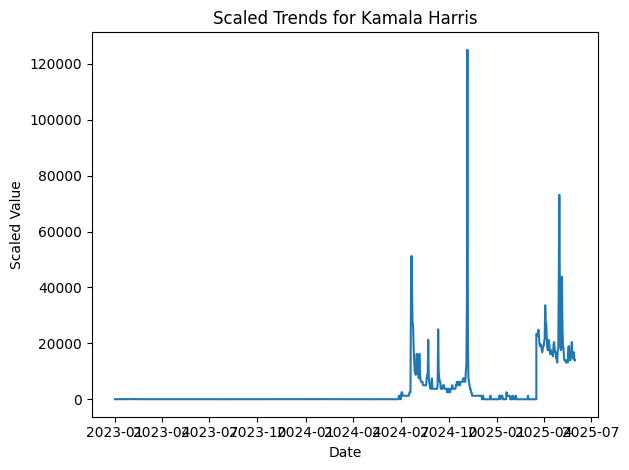

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
file_path = 'data/scaled_trends_bridge.csv'

# CSV 읽기
df = pd.read_csv(file_path)

# 컬럼 확인
print("Columns in CSV:", df.columns.tolist())

# 날짜 컬럼 자동 탐지
date_col = next((c for c in df.columns if 'date' in c.lower()), None)
if date_col is None:
    raise ValueError("No date-like column found in CSV.")

# 문자열을 datetime으로 변환
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# "Kamala Harris" 필터
df_kh = df[df['name'] == 'Kamala Harris']

if df_kh.empty:
    print("No records found for 'Kamala Harris'.")
else:
    # 플롯 그리기
    plt.figure()
    plt.plot(df_kh[date_col], df_kh['scaled_value'])
    plt.xlabel('Date')
    plt.ylabel('Scaled Value')
    plt.title('Scaled Trends for Kamala Harris')
    plt.tight_layout()
    plt.show()


In [14]:
import pandas as pd

# 파일 경로 설정
orig_fp    = 'data/scaled_trends.csv'
bridge_fp  = 'data/scaled_trends_bridge.csv'
merged_fp  = 'data/scaled_trends_merged_bridge.csv'
names_fp   = 'data/scaled_trends_merged_bridge_names.csv'

# 1) CSV 읽기
orig   = pd.read_csv(orig_fp, parse_dates=['date'])
bridge = pd.read_csv(bridge_fp, parse_dates=['date'])

# 2) 중복 제거: orig에서 bridge에 있는 (name, date) 행 삭제
#    fast membership check 을 위해 튜플 집합 생성
bridge_keys = set(zip(bridge['name'], bridge['date']))
mask = orig.apply(lambda row: (row['name'], row['date']) not in bridge_keys, axis=1)
orig_filtered = orig[mask]

# 3) 합치기
merged = pd.concat([orig_filtered, bridge], ignore_index=True)
merged.sort_values(['name', 'date'], inplace=True)

# 4) 결과 저장
merged.to_csv(merged_fp, index=False)

# 5) name 집합 저장
names_df = pd.DataFrame({'name': merged['name'].unique()})
names_df.to_csv(names_fp, index=False)

print(f"Merged saved to {merged_fp}")
print(f"Unique names saved to {names_fp}")


Merged saved to data/scaled_trends_merged_bridge.csv
Unique names saved to data/scaled_trends_merged_bridge_names.csv


In [15]:
import pandas as pd

# 파일 경로 설정
merged_fp      = 'data/scaled_trends_merged_bridge.csv'
final_fp       = 'final.csv'
info_output_fp = 'data/scaled_trends_merged_bridge_person_info.csv'

# 1) Merge 결과 읽기
merged = pd.read_csv(merged_fp)
merged_names = set(merged['name'].dropna().unique())

# 2) final.csv에서 모든 컬럼 읽기
final_df = pd.read_csv(final_fp)

# 3) Merge에 포함된 이름으로 final 정보 필터링
filtered_info = final_df[final_df['name'].isin(merged_names)]

# 4) 필터링된 정보 저장
filtered_info.to_csv(info_output_fp, index=False)

print(f"Person info saved to {info_output_fp}")


Person info saved to data/scaled_trends_merged_bridge_person_info.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
merge_jump_dates.py
────────────────────────────────────────────────────────────
· volatility_jumps_pos.csv → 인물별 jump 날짜(YYYYMMDD) 리스트 생성
· final.csv 과 머지 후 jump 없는 인물 행 제거
· 결과: final_with_jump_dates.csv
"""

from pathlib import Path
import pandas as pd

# ───────────────────────── 파일 경로
JUMP_CSV  = Path("data/volatility_jumps_pos_sh_esd_plus.csv")
FINAL_CSV = Path("final.csv")
OUT_CSV   = Path("final_with_jump_s_esd_plus.csv")

# ───────────────────────── 1) 점프 날짜 집계
jumps = (
    pd.read_csv(JUMP_CSV, parse_dates=["date"])
      .loc[lambda df: df["vol_jump"]]           # 혹시 모를 False 제외
)

# 날짜를 YYYYMMDD 정수로 변환
jumps["date_int"] = jumps["date"].dt.strftime("%Y%m%d").astype(int)

# 인물별 날짜 리스트
jump_dates = (s
    jumps.groupby("name")["date_int"]
         .apply(lambda x: sorted(x.unique().tolist()))   # 중복 제거·정렬
         .reset_index(name="vol_jump_dates")
)

# ───────────────────────── 2) final.csv 과 머지
final_df = pd.read_csv(FINAL_CSV)

merged = (
    final_df.merge(jump_dates, on="name", how="inner")   # jump 없는 인물 제거
          .sort_values("name")
          .reset_index(drop=True)
)

# ───────────────────────── 3) 저장
merged.to_csv(OUT_CSV, index=False)
print(f"✔ 저장 완료: {OUT_CSV} ({len(merged)} rows)")


✔ 저장 완료: final_with_jump_s_esd_plus.csv (293 rows)


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
google_trend_crawl_pytrends.py   (2025-07-02, full standalone)

Roy et al.(2023) 의 ‘일(日) → 월(月) 스케일 변환’ 알고리즘을
`pytrends.dailydata.get_daily_data()` 함수로 그대로 구현하였다. 
함수는 (i) 월별 전체 히트(0–100), (ii) 달별 일별 히트(0–100) 두 가지를
동시에 다운로드하고, 내부적으로 일별 × (월별 ÷ 100) 연산으로
**연속적이고 비교 가능** 한 일별 시계열을 반환한다.

출력 형식과 폴더 구조는 SerpApi 스크립트와 동일.
필수 패키지
──────────
pip install python-dotenv pandas python-dateutil pytrends tqdm
"""
from __future__ import annotations

import logging
import sys
from datetime import datetime, timezone
from pathlib import Path
from typing import List

import pandas as pd
from dotenv import load_dotenv         # 환경변수(x 필요하지만 일관성 유지용)
from pytrends.dailydata import get_daily_data   # core 함수
from tqdm import tqdm

# ────────────────────────────── 설정
START_YEAR, START_MONTH = 2023, 1
END_YEAR,   END_MONTH   = 2025, 5

RAW_CSV    = Path("data/raw_pytrends.csv")
SCALED_CSV = Path("data/scaled_pytrends.csv")
BAD_CSV    = Path("data/unlinkable_keywords_py.csv")

LOG_FILE   = Path("logs/trend_crawler_pytrends.log")
CACHE_DIR  = Path("cache/pytrends_parquet")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────── 로깅
LOG_FILE.parent.mkdir(parents=True, exist_ok=True)
fmt = logging.Formatter("%(asctime)s %(levelname)s %(message)s")

file_handler = logging.FileHandler(LOG_FILE, mode="a", encoding="utf-8")
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(fmt)

console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))

logger = logging.getLogger("pytrends")
if not logger.handlers:
    logger.setLevel(logging.DEBUG)
    logger.addHandler(file_handler)
    logger.addHandler(console)
else:
    if not any(isinstance(h, logging.StreamHandler) and h.stream is sys.stdout
               for h in logger.handlers):
        logger.addHandler(console)

# ────────────────────────────── util
def fetch_daily_scaled(keyword: str,
                       start_y: int, start_m: int,
                       end_y: int, end_m: int,
                       geo: str = "") -> pd.DataFrame:
    """
    get_daily_data() → 일별 value 열(Already Scaled), season = YYYY-MM.
    결과는 parquet 캐시로 저장.
    """
    cache_fp = CACHE_DIR / f"{keyword}_{start_y}{start_m:02d}_{end_y}{end_m:02d}.parquet"
    if cache_fp.exists():
        return pd.read_parquet(cache_fp)

    df = get_daily_data(keyword, start_y, start_m, end_y, end_m, geo=geo)

    # pytrends 열 이름:
    #   keyword              ← 일별 히트(스케일 완료)
    #   f'{kw}_unscaled'     ← 달 내부 0–100
    #   f'{kw}_monthly'      ← 월별 0–100
    #   'scale'              ← 적용된 스케일 계수
    daily_col   = keyword
    monthly_col = f"{keyword}_monthly"

    df.reset_index(inplace=True)           # index → 'date'
    df.rename(columns={daily_col: "value",
                       monthly_col: "monthly_raw"}, inplace=True)

    # 전체 월이 0 → 링크 불가
    if df["monthly_raw"].sum() == 0:
        raise ValueError("all-zero monthly hits")

    df["season"] = df["date"].dt.strftime("%Y-%m")
    df = df[["date", "value", "season"]]

    df.to_parquet(cache_fp, index=False)
    return df


def append_csv(p: Path, df: pd.DataFrame):
    header = not p.exists()
    df.to_csv(p, mode="a", header=header, index=False)


# ────────────────────────────── main
def main():
    # .env 호환 유지(딱히 쓸 API 없어도 로딩)
    load_dotenv()

    key_csv = Path("final.csv")
    if not key_csv.exists():
        logger.error("final.csv 가 없습니다.")
        return
    keywords: List[str] = pd.read_csv(key_csv, usecols=["name"])["name"].dropna().unique().tolist()
    logger.info("Loaded %d keywords", len(keywords))

    RAW_CSV.parent.mkdir(parents=True, exist_ok=True)
    for p in (RAW_CSV, SCALED_CSV, BAD_CSV):
        if not p.exists():
            p.parent.mkdir(parents=True, exist_ok=True)
            p.write_text("")

    for kw in tqdm(keywords, desc="Keywords"):
        try:
            df = fetch_daily_scaled(kw, START_YEAR, START_MONTH, END_YEAR, END_MONTH, geo="")
        except ValueError as e:          # 월 전체 0
            logger.info("⏭  %s skipped – %s", kw, e)
            append_csv(BAD_CSV, pd.DataFrame([{"name": kw, "reason": str(e)}]))
            continue

        # 논문 단계 ②: 전체 기간에서 최대값 → 100으로 재정규화
        df["scaled_value"] = (df["value"] / df["value"].max()) * 100

        raw_out    = df.assign(name=kw)[["name", "date", "value", "season"]]
        scaled_out = df.assign(name=kw)[["name", "date", "value", "season", "scaled_value"]]
        append_csv(RAW_CSV, raw_out)
        append_csv(SCALED_CSV, scaled_out)

        logger.info("✔︎  %s 완료 (%d rows)", kw, len(raw_out))

    logger.info("All done → %s / %s / %s", RAW_CSV, SCALED_CSV, BAD_CSV)


if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        logger.warning("Interrupted by user. Exit.")


INFO: Loaded 347 keywords


Keywords:   0%|          | 0/347 [00:00<?, ?it/s]

Donald Trump:2023-01-01 2023-01-31
Donald Trump:2023-02-01 2023-02-28
Donald Trump:2023-03-01 2023-03-31
Donald Trump:2023-04-01 2023-04-30
Donald Trump:2023-05-01 2023-05-31
Donald Trump:2023-06-01 2023-06-30
Donald Trump:2023-07-01 2023-07-31
Donald Trump:2023-08-01 2023-08-31
Donald Trump:2023-09-01 2023-09-30
Donald Trump:2023-10-01 2023-10-31
Donald Trump:2023-11-01 2023-11-30
Donald Trump:2023-12-01 2023-12-31
Donald Trump:2024-01-01 2024-01-31
Donald Trump:2024-02-01 2024-02-29
Donald Trump:2024-03-01 2024-03-31


Keywords:   0%|          | 0/347 [01:41<?, ?it/s]

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
google_trend_crawl_monthscale.py  (2025-07-02)

• final.csv 의 name 열을 읽어 2023-01-01~2025-05-31(UTC) 기간
  - ① [전 기간] 주간 GSV → 월 스케일(month_scale) 추출
  - ② [각 달]  일간 GSV 수집 → scaled_value = daily * (month_scale / 100)
• 결과 CSV
  · data/raw_trends.csv        name,date,value
  · data/scaled_trends.csv     name,date,value,scaled_value
  · data/unlinkable_keywords.csv name,reason
"""
from __future__ import annotations

import json, logging, os, sys
from datetime import datetime, timedelta, timezone
from pathlib import Path
from typing import List

import pandas as pd
from dotenv import load_dotenv
from serpapi import GoogleSearch
from tqdm import tqdm

# ────────────────────────────── 설정
START = datetime(2023, 1, 1, tzinfo=timezone.utc)
END   = datetime(2025, 6, 30, tzinfo=timezone.utc)

RAW_CSV    = Path("data/raw_trends_2.csv")
SCALED_CSV = Path("data/scaled_trends_2.csv")
BAD_CSV    = Path("data/unlinkable_keywords_2.csv")

LOG_FILE   = Path("logs/trend_crawler.log")
CACHE_DIR  = Path("cache/trends_json_2"); CACHE_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────── 로깅
fmt = logging.Formatter("%(asctime)s %(levelname)s | %(message)s")
LOG_FILE.parent.mkdir(parents=True, exist_ok=True)
fh = logging.FileHandler(LOG_FILE, mode="a", encoding="utf-8"); fh.setFormatter(fmt)
ch = logging.StreamHandler(sys.stdout); ch.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
logger = logging.getLogger()
logger.setLevel(logging.DEBUG); logger.addHandler(fh); logger.addHandler(ch)

# ────────────────────────────── API 키
load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY") or sys.exit("SERPAPI_KEY 없음 (.env)")

# ────────────────────────────── 공통 함수
def serpapi_call(q: str, date_param: str) -> dict:
    params = {"engine": "google_trends", "api_key": API_KEY, "q": q,
              "data_type": "TIMESERIES", "date": date_param, "output": "json"}
    cache_fp = CACHE_DIR / f"{q}_{date_param.replace(' ','_')}.json"
    if cache_fp.exists():
        return json.loads(cache_fp.read_text(encoding="utf-8"))
    data = GoogleSearch(params).get_dict(); cache_fp.write_text(json.dumps(data), encoding="utf-8")
    return data

def timeline_to_df(tl: list[dict], q: str) -> pd.DataFrame:
    rows = []
    for item in tl:
        ts = int(item.get("timestamp", 0))
        if not ts: continue
        d  = pd.to_datetime(ts, unit="s", utc=True)
        val = int(item["values"][0]["extracted_value"]) if "values" in item else int(item["value"])
        rows.append({"date": d, "value": val, "query": q})
    return pd.DataFrame(rows)

# ────────────────────────────── 월 스케일 구하기
def fetch_month_scales(keyword: str) -> pd.Series:
    data = serpapi_call(keyword, f"{START:%Y-%m-%d} {END:%Y-%m-%d}")
    tl = data.get("interest_over_time", {}).get("timeline_data", [])
    if not tl:
        return pd.Series(dtype=int)
    weekly = timeline_to_df(tl, keyword).set_index("date")["value"]
    month_scale = weekly.resample("M").max().astype(int)      # 월별 최대값 사용
    month_scale.index = month_scale.index.tz_localize("UTC") # index 일치
    return month_scale

# ────────────────────────────── 일간 데이터 수집 → 재스케일
def fetch_month_daily(keyword: str, month_start: datetime, month_end: datetime,
                      month_scale: int) -> pd.DataFrame:
    if month_scale == 0:  # 스케일 0 → 그대로 0
        dts = pd.date_range(month_start, month_end, freq="D", tz="UTC")
        return pd.DataFrame({"date": dts, "value": 0, "scaled_value": 0})
    data = serpapi_call(keyword, f"{month_start:%Y-%m-%d} {month_end:%Y-%m-%d}")
    tl = data.get("interest_over_time", {}).get("timeline_data", [])
    if not tl:
        logger.warning("%s: 일간 데이터 없음 %s", keyword, month_start.date())
        return pd.DataFrame()
    daily = timeline_to_df(tl, keyword)
    daily["scaled_value"] = daily["value"] * (month_scale / 100)
    return daily[["date", "value", "scaled_value"]]

# ────────────────────────────── main
def main():
    kw_list = pd.read_csv("final.csv", usecols=["name"])["name"].dropna().unique().tolist()
    for p in (RAW_CSV, SCALED_CSV, BAD_CSV):
        if not p.exists(): p.parent.mkdir(parents=True, exist_ok=True); p.write_text("")

    months = pd.period_range(START, END, freq="M")

    for kw in tqdm(kw_list, desc="Keywords"):
        month_scales = fetch_month_scales(kw)
        if month_scales.empty:
            append = pd.DataFrame([{"name": kw, "reason": "no_month_scale"}])
            append.to_csv(BAD_CSV, mode="a", header=False, index=False)
            continue

        raw_rows, scaled_rows = [], []
        for m in months:
            ms, me = m.start_time, m.end_time
            scale_val = month_scales.get(me, 0)
            df_month = fetch_month_daily(kw, ms, me, scale_val)
            if df_month.empty: continue
            raw_rows.append(df_month[["date", "value"]].copy())
            scaled_rows.append(df_month)

        if not raw_rows:
            pd.DataFrame([{"name": kw, "reason": "empty_all_months"}]).to_csv(
                BAD_CSV, mode="a", header=False, index=False)
            continue

        raw_all = pd.concat(raw_rows, ignore_index=True);  raw_all.insert(0, "name", kw)
        scaled_all = pd.concat(scaled_rows, ignore_index=True); scaled_all.insert(0, "name", kw)

        raw_all.to_csv(RAW_CSV, mode="a", header=not RAW_CSV.stat().st_size, index=False)
        scaled_all.to_csv(SCALED_CSV, mode="a", header=not SCALED_CSV.stat().st_size, index=False)

        logger.info("✔ %s (%d rows)", kw, len(raw_all))

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        logger.warning("Interrupted by user")
